# **Part 1: Understanding where our datset comes from : Kaggle dataset load**

#### I will load my dataset from kaggle, join the 19 Dataframes and merge them.


In [ ]:
import sys
sys.path.append('src/utils') 

from ToolBox import cardinalidad, describe_df



In [84]:

import pandas as pd
import numpy as np
from functools import reduce
import os
import kagglehub
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import shapiro
from scipy.stats import skew
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')


In [ ]:

# Download latest version
path = kagglehub.dataset_download("georgejdinicola/world-bank-indicators")

print("Path to dataset files:", path)

# Path to the downloaded dataset
csv_dir = pathlib.Path("/Users/Martagilant/.cache/kagglehub/datasets/georgejdinicola/world-bank-indicators/versions/7")

# Exclude helper files (optional)
EXCLUDE_FILES = {
    "world-bank-indicator-mapping.csv",
    "world_bank_indicators.csv"
}

# Load all CSVs
csv_paths = sorted(
    p for p in csv_dir.rglob("*.csv")
    if p.name not in EXCLUDE_FILES
)

dfs = []
for path in csv_paths:
    try:
        df = pd.read_csv(path, dtype={"year": "int64", "country": "string"})
        dfs.append(df)
        print(f"Loaded: {path.name}, shape: {df.shape}")
    except Exception as e:
        print(f"Failed to load {path.name}: {e}")

# This assumes `dfs` already contains the 19 loaded dataframes (do NOT redefine dfs = ...)

# Step 1: Check if dfs is valid
if not dfs or not all(isinstance(df, pd.DataFrame) for df in dfs):
    print("❌ ERROR: `dfs` is empty or invalid. Please load the CSVs first.")
else:
    # Step 2: Merge all on year + country
    def merge_dfs(left, right):
        return pd.merge(left, right, on=["year", "country"], how="outer")

    merged = reduce(merge_dfs, dfs)
    merged.replace([np.inf, -np.inf], np.nan, inplace=True)
    merged_cleaned = merged.dropna(axis=1, how='all').dropna(axis=0, how='all')

    # Step 3: Export to src/data_sample
    output_path = "src/data_sample/merged_world_bank_data.csv"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    merged_cleaned.to_csv(output_path, index=False)
    print(f"✅ Merged CSV saved to: {output_path}")



## For GDP growth predictions there are some fundamental economic drivers:

Most Important Features:

- Lagged GDP growth - Past growth strongly predicts future growth

- Investment rate (Gross fixed capital formation % of GDP) - Key growth driver

- Savings rate - Funds future investment

- Trade balance - External sector health

- Inflation - Macroeconomic stability indicator

### This merged model has 803 columns and ~ 17000 rows, because of this I have decided to, before I even begin my analysis, to get rid of some DataFrames and columns, to allow for a more efficient and faster model. 

### Some columns I decided to get rid of were due to:

🚫 Data Leakage - Some growth rates might not be available when making real predictions

🔄 Circular Logic - GDP components that are essentially the same as your target variable

📊 Scale Issues - Absolute values vary dramatically by country size; ratios are more meaningful

🔍 Too Granular - Individual aid flows add noise without predictive power

📈 Multicollinearity - Many GDP-related variables are highly correlated

### The golden rule: If a variable is basically another way of measuring GDP or requires knowing GDP to calculate it, I will exclude it.
I will keep:

Ratios and percentages (% of GDP, % of population)

Growth rates (but not future ones)

Structural indicators (education, infrastructure)

Policy variables (investment rates, trade openness)

Lagged versions of your target variable


###  * Information can be found here: https://datatopics.worldbank.org/world-development-indicators/themes/economy.html#:~:text=Economic%20indicators%20include%20measures%20of%20macroeconomic%20performance,money%20supply%2C%20and%20the%20balance%20of%20payments).&text=Many%20WDI%20indicators%20use%20GDP%20or%20GDP,cross%2Dcountry%20comparisons%20of%20socioeconomic%20and%20other%20data.




In [ ]:
import pandas as pd
import numpy as np

# Complete list of columns to exclude from GDP growth model
columns_to_exclude = [
    # Future-looking data (Data Leakage Risk)
    "Adjusted net national income (annual % growth)",
    "Final consumption expenditure (annual % growth)", 
    "Gross capital formation (annual % growth)",
    "Households and NPISHs Final consumption expenditure (annual % growth)",
    
    # GDP-related variables (Circular Logic)
    "GDP (current US$)",
    "GDP (constant 2015 US$)", 
    "GDP, PPP (current international $)",
    "GDP, PPP (constant 2021 international $)",
    "GDP per capita (current US$)",
    "GDP per capita, PPP (current international $)",
    "GDP per capita, PPP (constant 2021 international $)",
    "GNI (current US$)",
    "GNI (constant 2015 US$)",
    "GNI, PPP (current international $)", 
    "GNI, PPP (constant 2021 international $)",
    "GNI per capita (current US$)",
    "GNI per capita, PPP (current international $)",
    "GNI per capita, PPP (constant 2021 international $)",
    "GNI, Atlas method (current US$)",
    "GNI per capita, Atlas method (current US$)",
    "Gross value added at basic prices (GVA) (current US$)",
    "Gross value added at basic prices (GVA) (constant 2015 US$)",
    "Final consumption expenditure (current US$)",
    "Final consumption expenditure (constant 2015 US$)",
    "Gross national expenditure (current US$)",
    "Gross national expenditure (constant 2015 US$)",
    
    # Absolute values (prefer ratios/percentages)
    "Population, total",
    "Rural population",
    "General government final consumption expenditure (current US$)",
    "General government final consumption expenditure (constant 2015 US$)",
    "Households and NPISHs Final consumption expenditure (current US$)",
    "Households and NPISHs Final consumption expenditure (constant 2015 US$)",
    "Households and NPISHs Final consumption expenditure, PPP (current international $)",
    "Households and NPISHs Final consumption expenditure, PPP (constant 2021 international $)",
    "Gross fixed capital formation (current US$)",
    "Gross fixed capital formation (constant 2015 US$)",
    "Gross capital formation (current US$)",
    "Gross capital formation (constant 2015 US$)",
    "Gross domestic savings (current US$)",
    "Agriculture, forestry, and fishing, value added (current US$)",
    "Agriculture, forestry, and fishing, value added (constant 2015 US$)",
    "Manufacturing, value added (current US$)",
    "Industry (including construction), value added (current US$)",
    "Industry (including construction), value added (constant 2015 US$)",
    "Services, value added (current US$)",
    "Services, value added (constant 2015 US$)",
    "Agricultural land (sq. km)",
    "Forest area (sq. km)",
    "Land under cereal production (hectares)",
    
    # Detailed aid flows (too granular)
    "Net bilateral aid flows from DAC donors, Australia (current US$)",
    "Net bilateral aid flows from DAC donors, Austria (current US$)",
    "Net bilateral aid flows from DAC donors, Belgium (current US$)",
    "Net bilateral aid flows from DAC donors, Canada (current US$)",
    "Net bilateral aid flows from DAC donors, European Union institutions (current US$)",
    "Net bilateral aid flows from DAC donors, Switzerland (current US$)",
    "Net bilateral aid flows from DAC donors, Czechia (current US$)",
    "Net bilateral aid flows from DAC donors, Germany (current US$)",
    "Net bilateral aid flows from DAC donors, Denmark (current US$)",
    "Net bilateral aid flows from DAC donors, Spain (current US$)",
    "Net bilateral aid flows from DAC donors, Finland (current US$)",
    "Net bilateral aid flows from DAC donors, France (current US$)",
    "Net bilateral aid flows from DAC donors, United Kingdom (current US$)",
    "Net bilateral aid flows from DAC donors, Greece (current US$)",
    "Net bilateral aid flows from DAC donors, Hungary (current US$)",
    "Net bilateral aid flows from DAC donors, Ireland (current US$)",
    "Net bilateral aid flows from DAC donors, Iceland (current US$)",
    "Net bilateral aid flows from DAC donors, Italy (current US$)",
    "Net bilateral aid flows from DAC donors, Japan (current US$)",
    "Net bilateral aid flows from DAC donors, Korea, Rep. (current US$)",
    "Net bilateral aid flows from DAC donors, Luxembourg (current US$)",
    "Net bilateral aid flows from DAC donors, Netherlands (current US$)",
    "Net bilateral aid flows from DAC donors, Norway (current US$)",
    "Net bilateral aid flows from DAC donors, New Zealand (current US$)",
    "Net bilateral aid flows from DAC donors, Poland (current US$)",
    "Net bilateral aid flows from DAC donors, Portugal (current US$)",
    "Net bilateral aid flows from DAC donors, Slovak Republic (current US$)",
    "Net bilateral aid flows from DAC donors, Slovenia (current US$)",
    "Net bilateral aid flows from DAC donors, Sweden (current US$)",
    "Net bilateral aid flows from DAC donors, United States (current US$)",
    
    # UN agency flows
    "Net official flows from UN agencies, FAO (current US$)",
    "Net official flows from UN agencies, IAEA (current US$)",
    "Net official flows from UN agencies, IFAD (current US$)",
    "Net official flows from UN agencies, ILO (current US$)",
    "Net official flows from UN agencies, UNAIDS (current US$)",
    "Net official flows from UN agencies, UNICEF (current US$)",
    "Net official flows from UN agencies, UNHCR (current US$)",
    "Net official flows from UN agencies, UNDP (current US$)",
    "Net official flows from UN agencies, UNECE (current US$)",
    "Net official flows from UN agencies, UNEP (current US$)",
    "Net official flows from UN agencies, UNFPA (current US$)",
    "Net official flows from UN agencies, UNPBF (current US$)",
    "Net official flows from UN agencies, UNRWA (current US$)",
    "Net official flows from UN agencies, UNTA (current US$)",
    "Net official flows from UN agencies, UNWTO (current US$)",
    "Net official flows from UN agencies, WFP (current US$)",
    "Net official flows from UN agencies, WHO (current US$)",
    
    # Detailed education metrics
    "Trained teachers in preprimary education, female (% of female teachers)",
    "Trained teachers in preprimary education, male (% of male teachers)",
    "Trained teachers in primary education, male (% of male teachers)",
    "Trained teachers in secondary education, female (% of female teachers)",
    "Trained teachers in lower secondary education, female (% of female teachers)",
    "Trained teachers in lower secondary education, male (% of male teachers)",
    "Trained teachers in upper secondary education, female (% of female teachers)",
    "Trained teachers in upper secondary education, male (% of male teachers)",
    "Primary education, pupils",
    "Secondary education, pupils", 
    "Primary education, teachers",
    "Secondary education, teachers",
    
    # Balance of payments details
    "Communications, computer, etc. (% of service imports, BoP)",
    "Primary income payments (BoP, current US$)",
    "Service imports (BoP, current US$)",
    "Transport services (% of service imports, BoP)",
    "Secondary income, other sectors, payments (BoP, current US$)",
    "ICT service exports (% of service exports, BoP)",
    "Primary income receipts (BoP, current US$)",
    "Transport services (% of service exports, BoP)",
    "Secondary income receipts (BoP, current US$)",
]

# Function to clean dataset for GDP growth modeling
def clean_dataset_for_gdp_model(df, verbose=True):
    """
    Remove columns that should be excluded from GDP growth prediction model
    
    Parameters:
    df: pandas DataFrame - your merged dataset
    verbose: bool - whether to print progress information
    
    Returns:
    pandas DataFrame - cleaned dataset
    """
    
    if verbose:
        print("=== CLEANING DATASET FOR GDP GROWTH MODEL ===")
        print(f"Original dataset shape: {df.shape}")
    
    # Check which excluded columns actually exist in the dataset
    existing_exclusions = [col for col in columns_to_exclude if col in df.columns]
    missing_exclusions = [col for col in columns_to_exclude if col not in df.columns]
    
    if verbose:
        print(f"\nColumns to exclude that exist in dataset: {len(existing_exclusions)}")
        print(f"Columns to exclude that don't exist: {len(missing_exclusions)}")
        
        if missing_exclusions[:5]:  # Show first 5 missing ones
            print(f"Examples of missing columns: {missing_exclusions[:5]}")
    
    # Remove the columns
    cleaned_df = df.drop(columns=existing_exclusions)
    
    if verbose:
        print(f"\nAfter removing excluded columns: {cleaned_df.shape}")
        print(f"Removed {len(existing_exclusions)} columns")
        print(f"Remaining {cleaned_df.shape[1]} columns")
        
        # Show remaining column types
        remaining_cols = list(cleaned_df.columns)
        print(f"\nRemaining columns include:")
        print(f"  - Core identifiers: year, country")
        print(f"  - Target variable: GDP growth (annual %)")
        print(f"  - Economic ratios and percentages")
        print(f"  - Growth rates and structural indicators")
    
    return cleaned_df

# Apply the cleaning to your merged dataset
# Assuming your merged dataset is called 'merged_cleaned'
gdp_model_data = clean_dataset_for_gdp_model(merged_cleaned)

# Optional: Focus on most important features for initial modeling
key_features_for_modeling = [
    'year', 
    'country', 
    'GDP growth (annual %)',  # Target variable
    
    # Core economic indicators
    'GDP per capita (constant 2015 US$)',
    'Gross fixed capital formation (% of GDP)',
    'Gross domestic savings (% of GDP)', 
    'Inflation, GDP deflator (annual %)',
    
    # Trade and external
    'Exports of goods and services (% of GDP)',
    'Imports of goods and services (% of GDP)',
    'Foreign direct investment, net inflows (% of GDP)',
    
    # Structural factors
    'Population growth (annual %)',
    'Industry (including construction), value added (% of GDP)',
    'Agriculture, forestry, and fishing, value added (% of GDP)',
    'Services, value added (% of GDP)',
    
    # Human capital
    'School enrollment, secondary (% gross)',
    'Literacy rate, adult total (% of people ages 15 and above)',
    
    # Infrastructure
    'Access to electricity, rural (% of rural population)',
]

# Create focused dataset with key features only
print("\n" + "="*50)
print("CREATING FOCUSED DATASET FOR INITIAL MODELING")
print("="*50)

# Check which key features exist
existing_key_features = [col for col in key_features_for_modeling if col in gdp_model_data.columns]
missing_key_features = [col for col in key_features_for_modeling if col not in gdp_model_data.columns]

print(f"Key features available: {len(existing_key_features)}")
if missing_key_features:
    print(f"Missing key features: {missing_key_features}")

# Create focused dataset
focused_gdp_data = gdp_model_data[existing_key_features].copy()

print(f"Focused dataset shape: {focused_gdp_data.shape}")
print(f"Focused dataset columns: {list(focused_gdp_data.columns)}")

# Check data completeness
print(f"\nData completeness:")
completeness = (focused_gdp_data.notna().sum() / len(focused_gdp_data) * 100).round(1)
for col, pct in completeness.items():
    print(f"  {col}: {pct}%")

# Save the cleaned datasets
print(f"\nSaving cleaned datasets...")
gdp_model_data.to_csv("src/data_sample/gdp_model_full_cleaned.csv", index=False)
focused_gdp_data.to_csv("src/data_sample/gdp_model_focused.csv", index=False)
print(f"✅ Saved cleaned datasets to src/data_sample/")

In [3]:
#For now I will import the already merged dataset:
df = pd.read_csv("src/data_sample/gdp_model_focused.csv")


# **Part 2 : Understanding our business problem**

Because we are assuming that this is a GDP growth estimation by country, this is a Supervised Learning Regression problem.

(*Refer to **img** folder for a graph on Machine Learning problems*)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16900 entries, 0 to 16899
Data columns (total 17 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   year                                                        16900 non-null  int64  
 1   country                                                     16900 non-null  object 
 2   GDP growth (annual %)                                       13575 non-null  float64
 3   GDP per capita (constant 2015 US$)                          13695 non-null  float64
 4   Gross fixed capital formation (% of GDP)                    9793 non-null   float64
 5   Gross domestic savings (% of GDP)                           10497 non-null  float64
 6   Inflation, GDP deflator (annual %)                          13470 non-null  float64
 7   Exports of goods and services (% of GDP)                    10802 non-null  float64
 

In [6]:
df.columns

Index(['year', 'country', 'GDP growth (annual %)',
       'GDP per capita (constant 2015 US$)',
       'Gross fixed capital formation (% of GDP)',
       'Gross domestic savings (% of GDP)',
       'Inflation, GDP deflator (annual %)',
       'Exports of goods and services (% of GDP)',
       'Imports of goods and services (% of GDP)',
       'Foreign direct investment, net inflows (% of GDP)',
       'Population growth (annual %)',
       'Industry (including construction), value added (% of GDP)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Services, value added (% of GDP)',
       'School enrollment, secondary (% gross)',
       'Literacy rate, adult total (% of people ages 15 and above)',
       'Access to electricity, rural (% of rural population)'],
      dtype='object')

In [7]:
df["GDP growth (annual %)"].value_counts()

GDP growth (annual %)
 0.000000     15
 3.761612      2
 0.619467      2
 4.286275      2
 11.647093     2
              ..
-0.236337      1
 3.772402      1
 6.054514      1
 10.399009     1
 5.336730      1
Name: count, Length: 13434, dtype: int64

Interesting , there seems to be a wide range across the countries in terms of GDP growth annually

In [8]:
df.head()

,year,country,GDP growth (annual %),GDP per capita (constant 2015 US$),Gross fixed capital formation (% of GDP),Gross domestic savings (% of GDP),"Inflation, GDP deflator (annual %)",Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Population growth (annual %),"Industry (including construction), value added (% of GDP)","Agriculture, forestry, and fishing, value added (% of GDP)","Services, value added (% of GDP)","School enrollment, secondary (% gross)","Literacy rate, adult total (% of people ages 15 and above)","Access to electricity, rural (% of rural population)"
0,1960,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1960,AFE,NaN,1172.316285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1960,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1960,AFW,NaN,1110.513849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1960,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lots of **NaNs** that we will have to deal with later

In [9]:
df.value_counts()

year  country  GDP growth (annual %)  GDP per capita (constant 2015 US$)  Gross fixed capital formation (% of GDP)  Gross domestic savings (% of GDP)  Inflation, GDP deflator (annual %)  Exports of goods and services (% of GDP)  Imports of goods and services (% of GDP)  Foreign direct investment, net inflows (% of GDP)  Population growth (annual %)  Industry (including construction), value added (% of GDP)  Agriculture, forestry, and fishing, value added (% of GDP)  Services, value added (% of GDP)  School enrollment, secondary (% gross)  Literacy rate, adult total (% of people ages 15 and above)  Access to electricity, rural (% of rural population)
1990  MUS      7.186737               3810.480833                         30.176859                                  24.034973                         10.583631                           64.093928                                 71.196573                                 1.526106                                           0.712313            

# **Part 3: Analyzing Target**

#### Let´s look at target distributions through different plots

In [20]:
target = "GDP growth (annual %)"

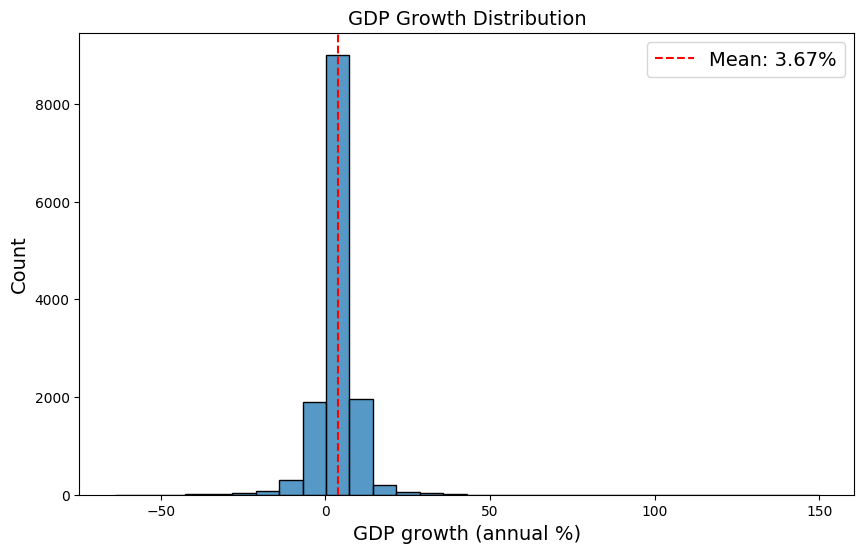

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="GDP growth (annual %)", bins=30)
plt.title('GDP Growth Distribution')
plt.axvline(df["GDP growth (annual %)"].mean(), color='red', linestyle='--', label=f'Mean: {df["GDP growth (annual %)"].mean():.2f}%')
plt.legend()
plt.show()

Good distribution of target, almost normal distribution, if slightly skewed to the right.

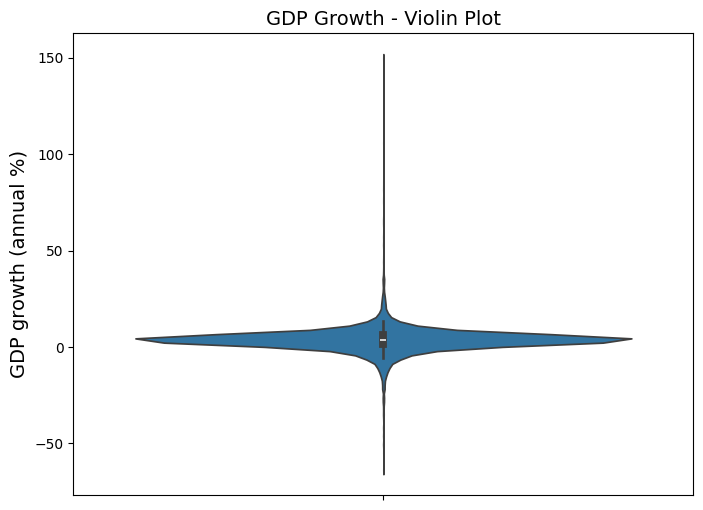

In [15]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, y="GDP growth (annual %)")
plt.title('GDP Growth - Violin Plot')
plt.show();

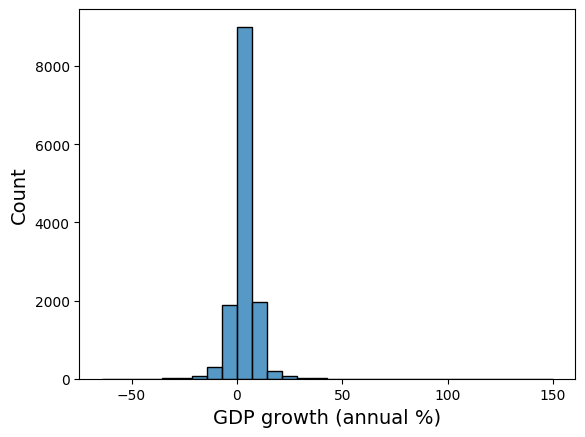

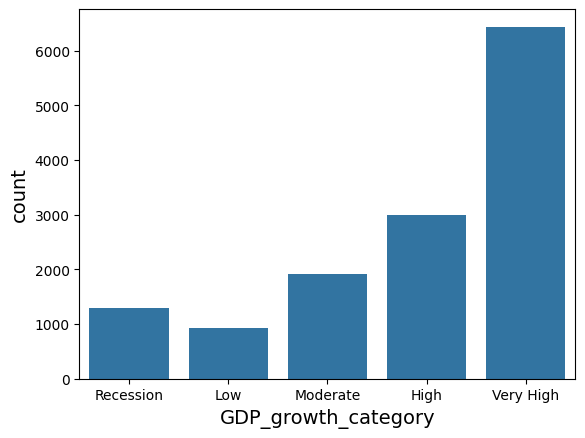

In [16]:

sns.histplot(data=df, x="GDP growth (annual %)", bins=30)
plt.show()

# Or if you want to bin the continuous values into categories first:
df['GDP_growth_category'] = pd.cut(df["GDP growth (annual %)"], 
                                  bins=[-float('inf'), -2, 0, 2, 4, float('inf')], 
                                  labels=['Recession', 'Low', 'Moderate', 'High', 'Very High'])
sns.countplot(data=df, x='GDP_growth_category')
plt.show()

##### We can see from here how theres a skew towards "Very High" GDP growth, followed by "High" and "Moderate", our dataset is imbalanced.

In [17]:
print("GDP Growth - Descriptive Statistics:")
print(df["GDP growth (annual %)"].describe())
print(f"\nSkewness: {df['GDP growth (annual %)'].skew():.3f}")
print(f"Kurtosis: {df['GDP growth (annual %)'].kurtosis():.3f}")

GDP Growth - Descriptive Statistics:
count    13575.000000
mean         3.669586
std          6.230779
min        -64.047107
25%          1.373394
50%          3.807604
75%          6.152008
max        149.972963
Name: GDP growth (annual %), dtype: float64

Skewness: 1.835
Kurtosis: 49.315


### Let´s fully look at all the plots:

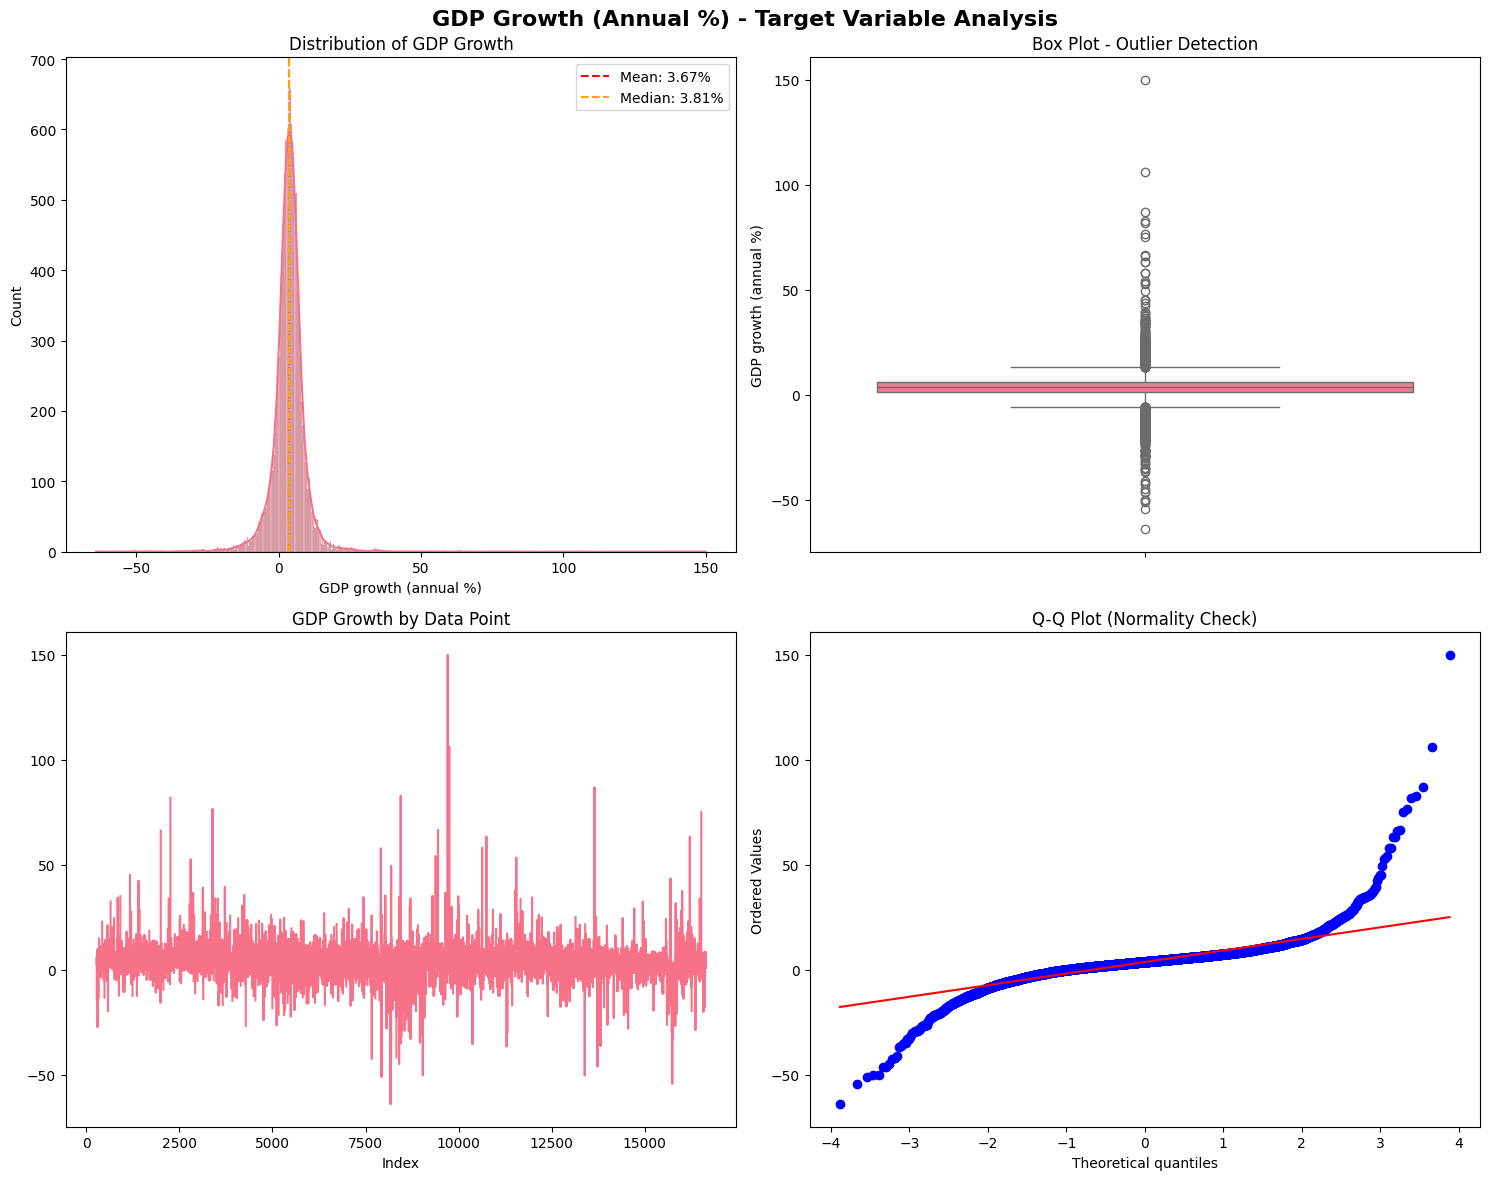

In [18]:
# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

# Create subplots for multiple visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('GDP Growth (Annual %) - Target Variable Analysis', fontsize=16, fontweight='bold')

# 1. Distribution plot (histogram + KDE)
sns.histplot(data=df, x="GDP growth (annual %)", kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribution of GDP Growth')
axes[0,0].axvline(df["GDP growth (annual %)"].mean(), color='red', linestyle='--', label=f'Mean: {df["GDP growth (annual %)"].mean():.2f}%')
axes[0,0].axvline(df["GDP growth (annual %)"].median(), color='orange', linestyle='--', label=f'Median: {df["GDP growth (annual %)"].median():.2f}%')
axes[0,0].legend()

# 2. Box plot to see outliers
sns.boxplot(data=df, y="GDP growth (annual %)", ax=axes[0,1])
axes[0,1].set_title('Box Plot - Outlier Detection')

# 3. Time series plot (if you have a time/date column)
# Replace 'Year' with your actual time column name
if 'Year' in df.columns:
    sns.lineplot(data=df, x="Year", y="GDP growth (annual %)", ax=axes[1,0])
    axes[1,0].set_title('GDP Growth Over Time')
    axes[1,0].tick_params(axis='x', rotation=45)
else:
    # If no time column, show a simple line plot by index
    axes[1,0].plot(df.index, df["GDP growth (annual %)"])
    axes[1,0].set_title('GDP Growth by Data Point')
    axes[1,0].set_xlabel('Index')

# 4. Q-Q plot to check normality
from scipy import stats
stats.probplot(df["GDP growth (annual %)"].dropna(), dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot (Normality Check)')

plt.tight_layout()
plt.show()

### Things to note:

Top left plot:


- The distribution is fairly symmetrical, but the small difference between mean and median suggests slight left skewness.

- Extreme outliers are evident (e.g., values beyond ±50%), likely due to crisis or recovery years in specific countries.

Top right plot:

- Shows a tight interquartile range (IQR), but a large number of extreme outliers on both tails (especially positive).

- Outliers go up to 150% GDP growth and down to −50%, which are very unusual economic conditions.

Bottom left plot:

- Shows volatile data  across observations.ç

- Frequent spikes suggest that we have highly variable countries or years — a mix of stable and unstable economies.

Bottom right plot:

- The blue dots deviate heavily from the red diagonal line, especially in the tails, this indicates non-normality of GDP growth.


- The S-shaped curve means:

    - Left tail is heavier than normal (more extreme negative GDPs).
    
    - Right tail is also heavy, showing rare booms


# **Part 4: Division into Train and Test**

In [22]:
df["target"] = df["GDP growth (annual %)"]
df.drop(columns = ["GDP growth (annual %)"], inplace = True)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("target", axis=1),
                                                    df['target'],
                                                    test_size=0.2,
                                                    random_state=42)

# **Part 5: Quick look Data**

In [24]:
X_train.columns

Index(['year', 'country', 'GDP per capita (constant 2015 US$)',
       'Gross fixed capital formation (% of GDP)',
       'Gross domestic savings (% of GDP)',
       'Inflation, GDP deflator (annual %)',
       'Exports of goods and services (% of GDP)',
       'Imports of goods and services (% of GDP)',
       'Foreign direct investment, net inflows (% of GDP)',
       'Population growth (annual %)',
       'Industry (including construction), value added (% of GDP)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Services, value added (% of GDP)',
       'School enrollment, secondary (% gross)',
       'Literacy rate, adult total (% of people ages 15 and above)',
       'Access to electricity, rural (% of rural population)',
       'GDP_growth_category'],
      dtype='object')

In [46]:
cardinalidad(X_train, 500, umbral_continua = 30)

,nombre_variable,valores_unicos,cardinalidad,tipo_sugerido
0,year,65,0.004808,Categórica
1,country,260,0.019231,Categórica
2,GDP per capita (constant 2015 US$),10854,0.802811,Numerica Discreta
3,Gross fixed capital formation (% of GDP),7740,0.572485,Numerica Discreta
4,Gross domestic savings (% of GDP),8346,0.617308,Numerica Discreta
5,"Inflation, GDP deflator (annual %)",9783,0.723595,Numerica Discreta
6,Exports of goods and services (% of GDP),8569,0.633802,Numerica Discreta
7,Imports of goods and services (% of GDP),8595,0.635725,Numerica Discreta
8,"Foreign direct investment, net inflows (% of GDP)",8778,0.649260,Numerica Discreta
9,Population growth (annual %),12965,0.958950,Numerica Discreta


In [48]:
def data_report(df):
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)


    return concatenado.T
        
data_report(X_train)

COL_N,year,country,GDP per capita (constant 2015 US$),Gross fixed capital formation (% of GDP),Gross domestic savings (% of GDP),"Inflation, GDP deflator (annual %)",Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Population growth (annual %),"Industry (including construction), value added (% of GDP)","Agriculture, forestry, and fishing, value added (% of GDP)","Services, value added (% of GDP)","School enrollment, secondary (% gross)","Literacy rate, adult total (% of people ages 15 and above)","Access to electricity, rural (% of rural population)",GDP_growth_category
DATA_TYPE,int64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,category
MISSINGS (%),0.0,0.0,19.08,42.17,37.97,20.38,36.06,35.96,33.53,3.3,37.4,36.92,40.77,44.53,84.06,56.64,19.78
UNIQUE_VALUES,65,260,10854,7740,8346,9783,8569,8595,8778,12965,8374,8440,7921,7421,1482,2007,5
CARDIN (%),0.48,1.92,80.28,57.25,61.73,72.36,63.38,63.57,64.93,95.89,61.94,62.43,58.59,54.89,10.96,14.84,0.04


In [47]:
# Estadísticos
X_train.describe()
X_train.describe(include='all')

# Tipos de los datos
X_train.dtypes

# Tipos de los datos y missings
X_train.info()

# Columnas del dataset
X_train.columns

# dimensiones del dataset
print("Filas:", X_train.shape[0])
print("Columnas:", X_train.shape[1])

<class 'pandas.core.frame.DataFrame'>
Index: 13520 entries, 3577 to 15795
Data columns (total 17 columns):
 #   Column                                                      Non-Null Count  Dtype   
---  ------                                                      --------------  -----   
 0   year                                                        13520 non-null  int64   
 1   country                                                     13520 non-null  object  
 2   GDP per capita (constant 2015 US$)                          10940 non-null  float64 
 3   Gross fixed capital formation (% of GDP)                    7818 non-null   float64 
 4   Gross domestic savings (% of GDP)                           8387 non-null   float64 
 5   Inflation, GDP deflator (annual %)                          10765 non-null  float64 
 6   Exports of goods and services (% of GDP)                    8645 non-null   float64 
 7   Imports of goods and services (% of GDP)                    8658 non-null   fl

### Mostly numerical values, Country may be an interetsing to trasnform later, as well as dealing with all the NaNs.

# **Part 6: Feature Reduction**

#### Some of my columns with more tha  40 % missing values I will not remove, due to the importance for prediction: Gross fixed capital formation (% of GDP) is the main one.

#### I will remove for now : 
- Services, value added (% of GDP)

- School enrollment, secondary (% gross)

- Literacy rate, adult total (% of people ages 15 and above)

- Access to electricity, rural (% of rural population)

- GDP_growth_category (I created it to visualize my data)

**They are being removed due to the % of missings.**

In [49]:
print("Columnas post drop:", len(X_train.columns))

Columnas post drop: 17


In [ ]:
X_train.drop(columns=["Services, value added (% of GDP)","School enrollment, secondary (% gross)", "Literacy rate, adult total (% of people ages 15 and above)","Access to electricity, rural (% of rural population)","GDP_growth_category" ], inplace=True)
X_test.drop(columns=["Services, value added (% of GDP)","School enrollment, secondary (% gross)", "Literacy rate, adult total (% of people ages 15 and above)","Access to electricity, rural (% of rural population)", "GDP_growth_category" ], inplace=True)

In [65]:
print("Columnas post drop:", len(X_train.columns))
#I won´t do anymore feature selection since I first need to handle missing values.

Columnas post drop: 12


# **Part 7: Univariant Analysis**

### ***See the end of Part 3 for the beginning of the analysis***

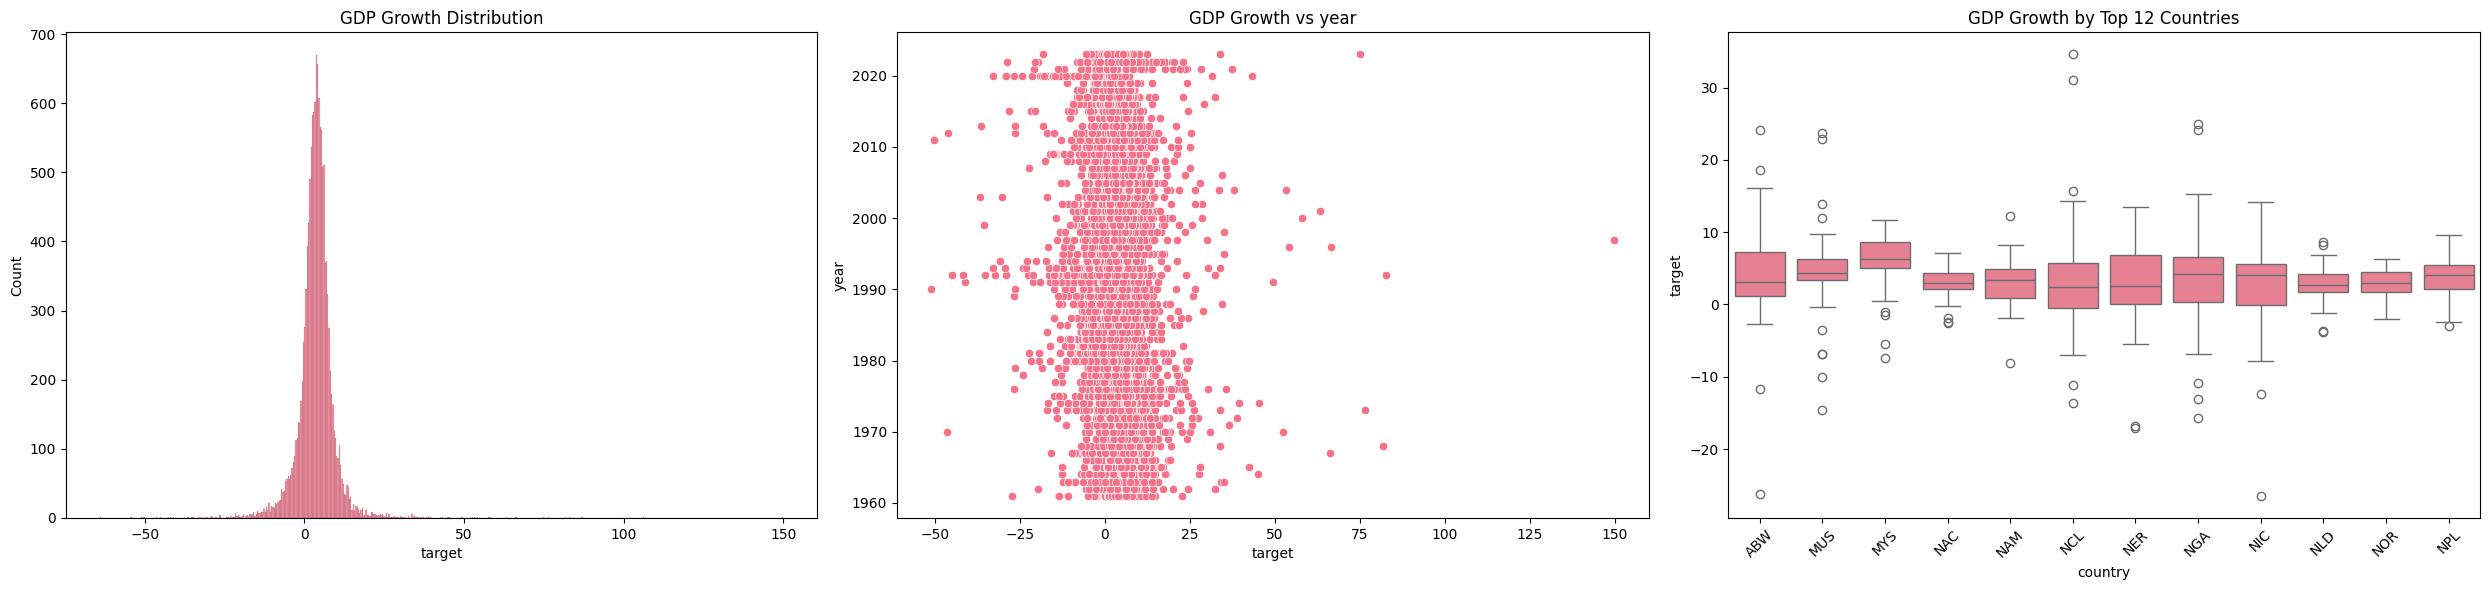

Total countries in dataset: 260
Showing top 12 countries by data availability


In [53]:
# Numeric vs categoric


fig, axes = plt.subplots(1, 3, figsize=(25, 6))

# Numeric target
sns.histplot(df["target"], ax=axes[0])
axes[0].set_title("GDP Growth Distribution")

# Numeric vs Numeric (assuming you have another numeric column)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
if len(numeric_cols) > 1:
    other_col = [col for col in numeric_cols if col != "target"][0]
    sns.scatterplot(x=df["target"], y=X_train[other_col], ax=axes[1])
    axes[1].set_title(f"GDP Growth vs {other_col}")

# Top countries only
top_countries = df['country'].value_counts().head(12).index
df_top = df[df['country'].isin(top_countries)]
sns.boxplot(data=df_top, x="country", y="target", ax=axes[2])
axes[2].set_title("GDP Growth by Top 12 Countries")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Optional: Show summary statistics for all countries
print(f"Total countries in dataset: {X_train['country'].nunique()}")
print(f"Showing top {len(top_countries)} countries by data availability")

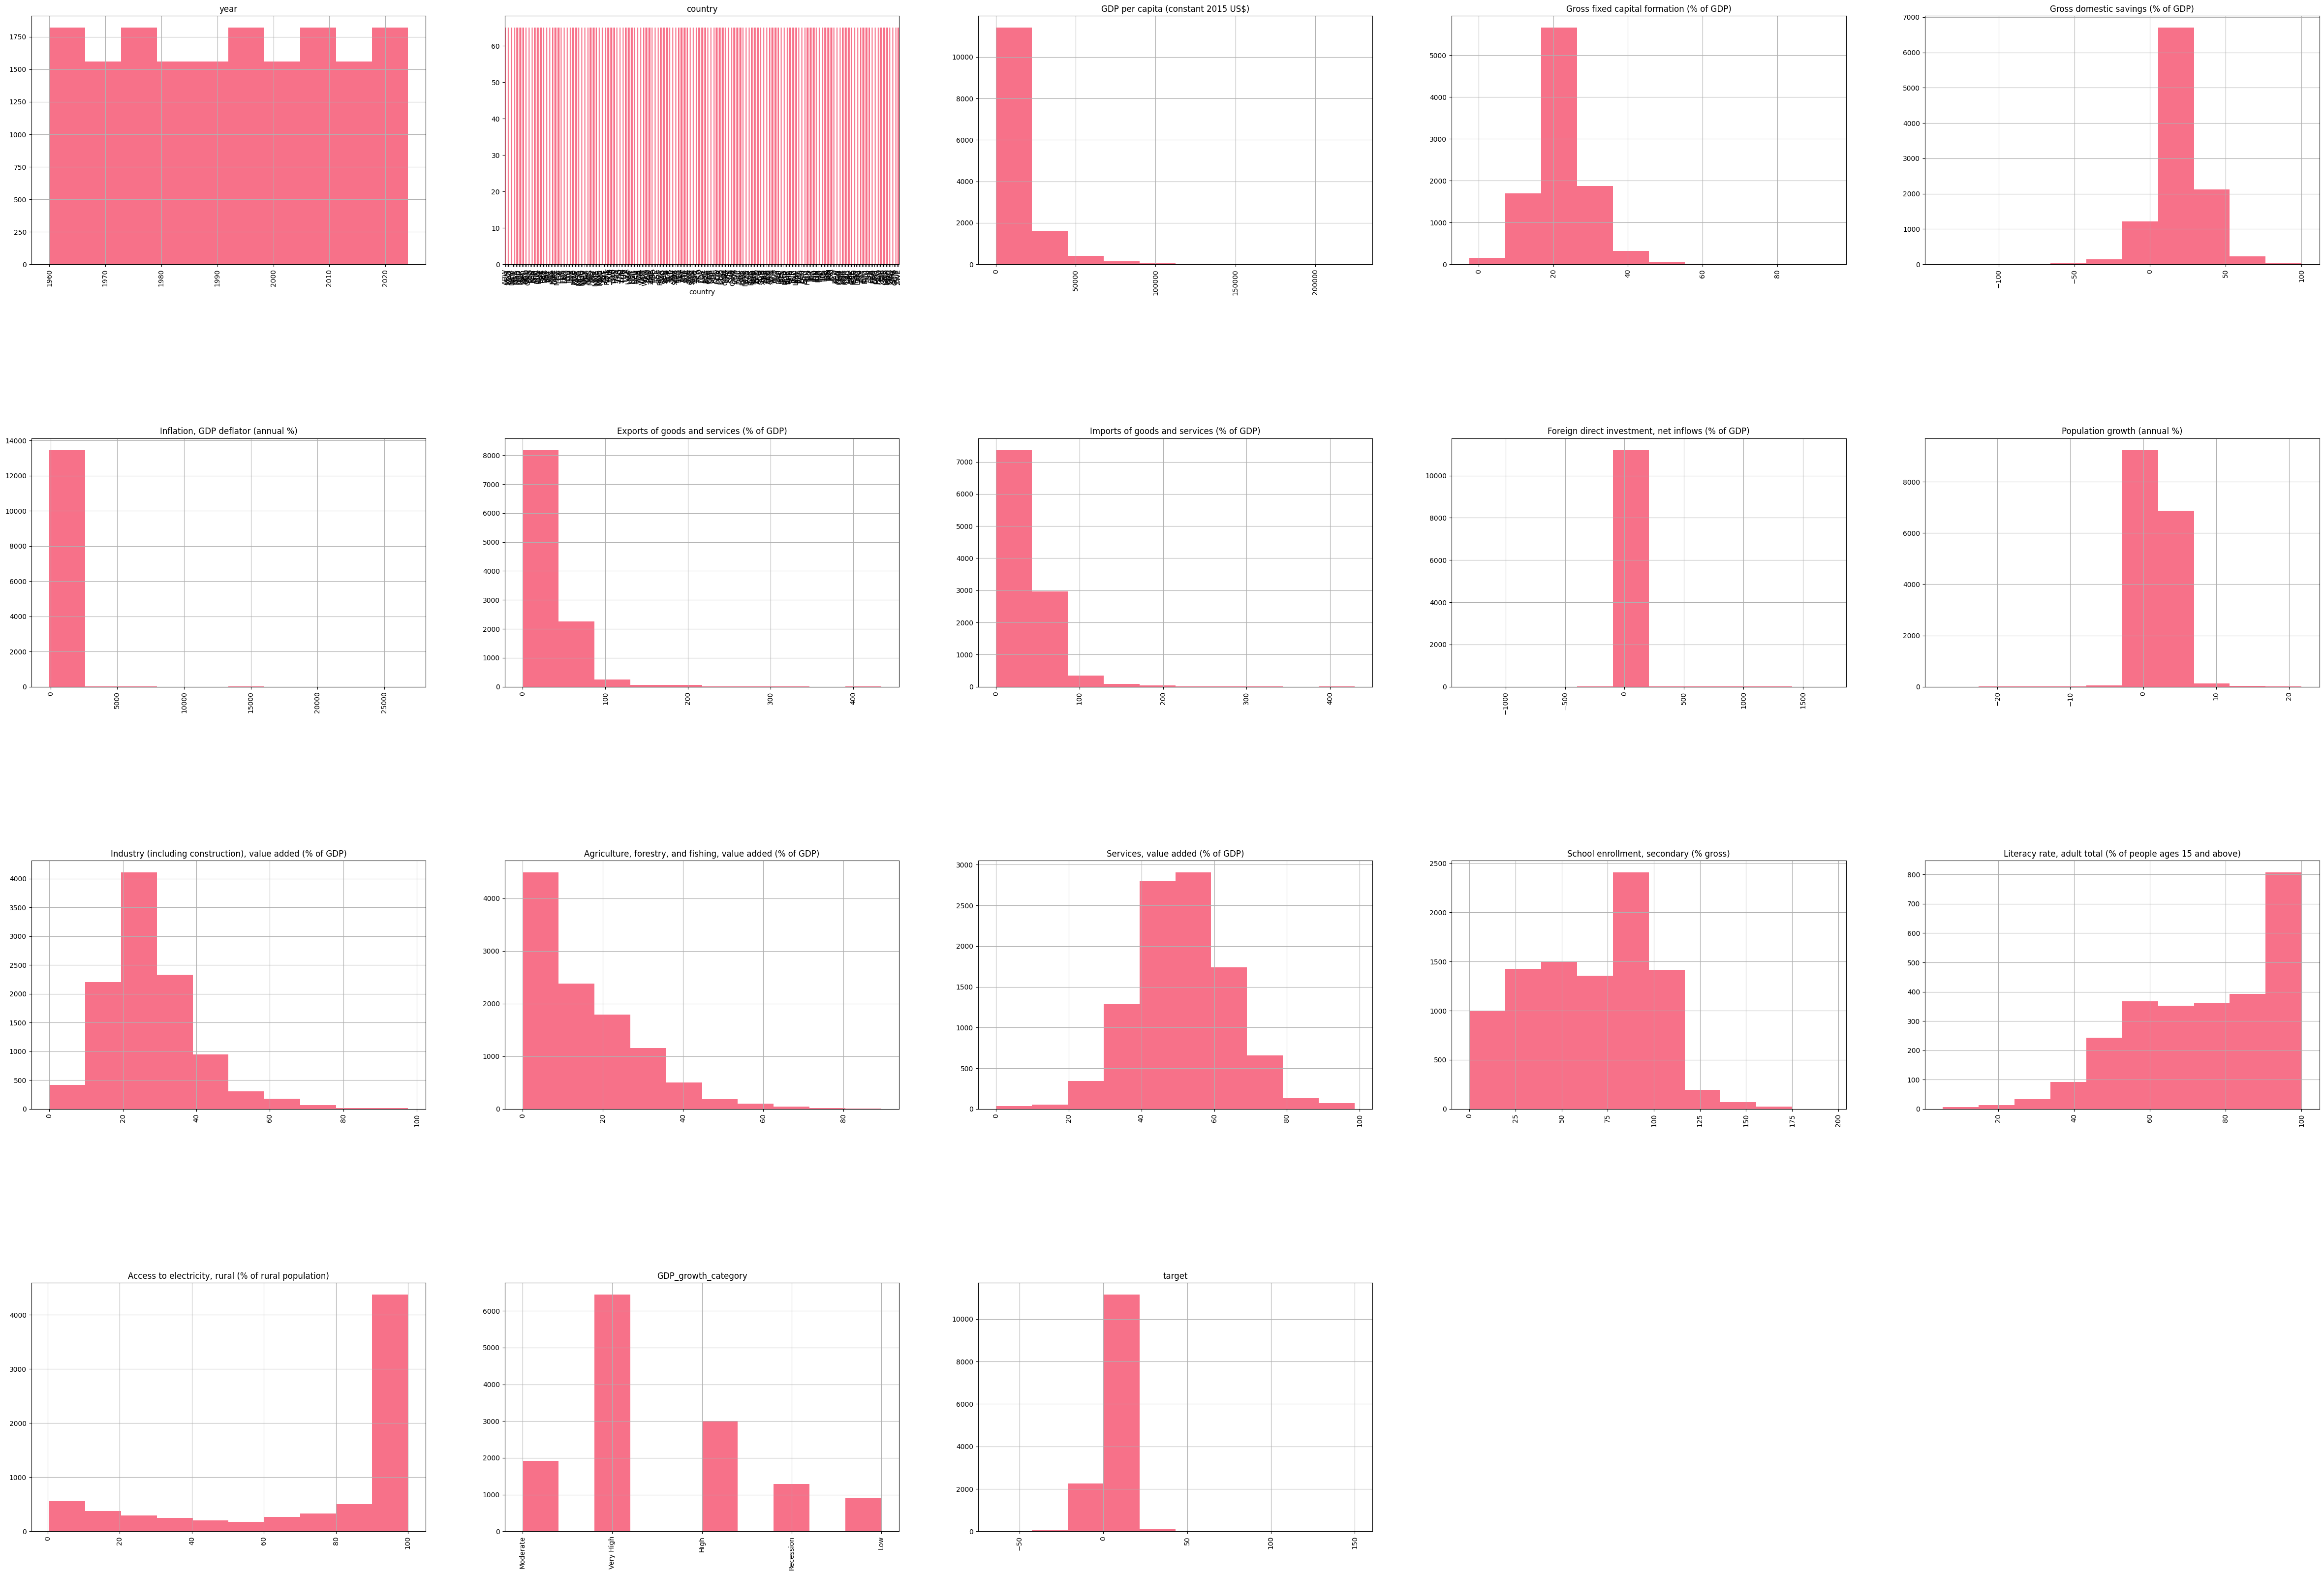

In [54]:
#Numerical features
fig = plt.figure(figsize=(60, 40))
cols = 5
rows = int(np.ceil(float(df.shape[1]) / cols))
for i, column in enumerate(df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if df.dtypes[column] == object:
        df[column].value_counts().plot(kind="bar", axes=ax)
    else:
        df[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)


### We can see that we´ll need to scale most of these values.

##### Features I´ll have to engineer from this graph: Agricultire, forestry...etc, GDP per capita, Gross fixed capital fomration, Exporta of goods, Imports of goods, Industry, population growth.

# **Part 8: Multivariant Analysis**

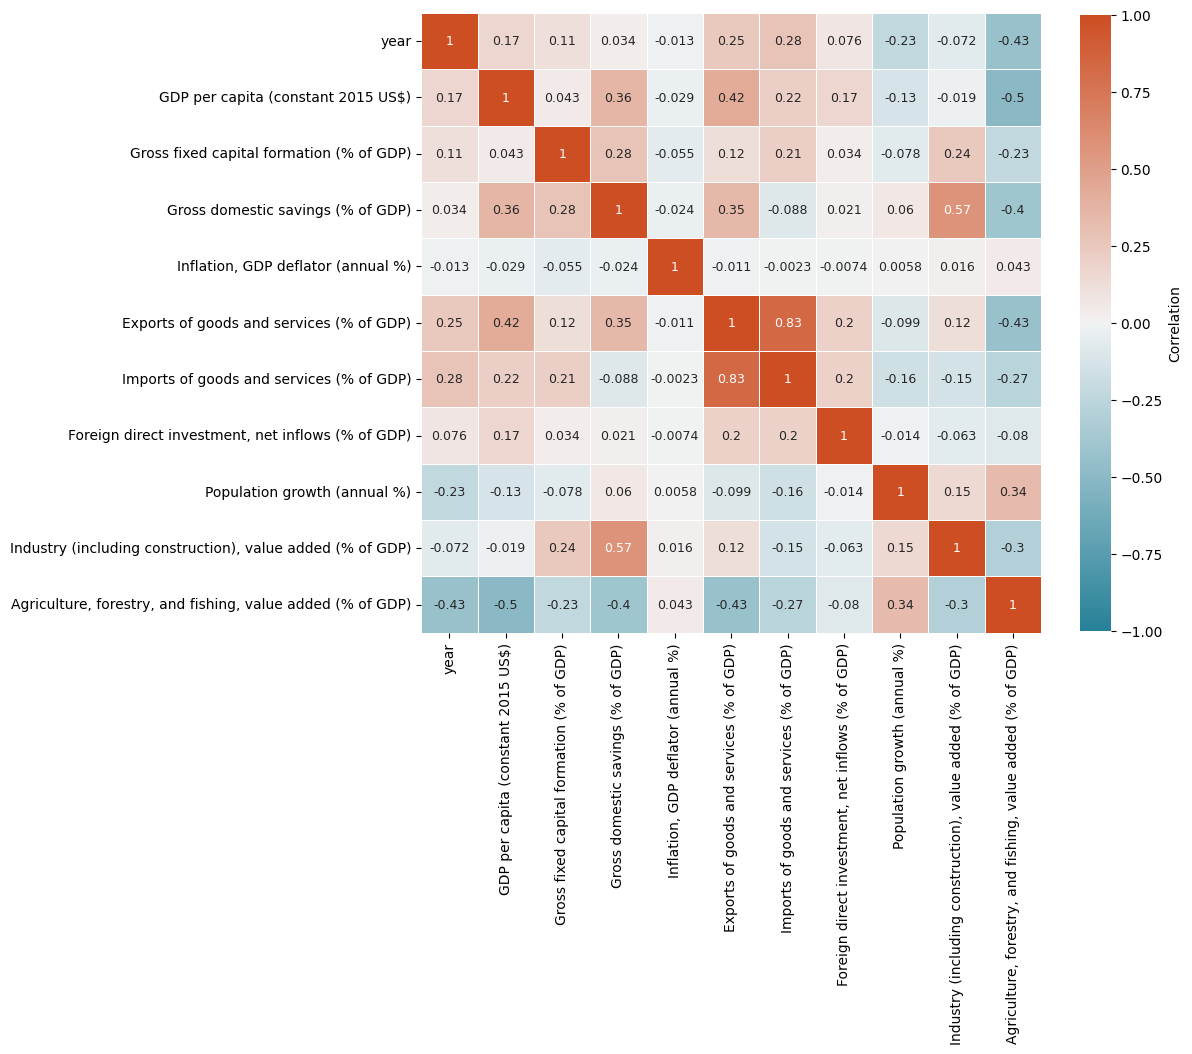

In [66]:
#Feature analysis, pairwise Pearson correlation coefficienbts between
# various economic indicators
plt.figure(figsize=(10, 10))

sns.heatmap(
    X_train.corr(numeric_only=True),
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(220, 20, as_cmap=True, s=90, l=50, n=256),
    square=True,
    annot=True,
    linewidths=0.5,
    annot_kws={"size": 9},
    cbar_kws={"shrink": 0.8, "label": "Correlation"}
);

Interesting positive correlations:

- Exports and Imports of goods and services (% of GDP) = 0.83

- Gross fixed capital formation and Industry value added = 0.57

- Gross domestic savings and Industry value added = 0.57

- GDP per  capita and Gross fixed capital formation = 0.36
Higher investment with higher capita income


Interesting negative correlations:

- Agriculture value added vs GDP per capita= -0.50
Economies that rely on agriculture may have lower per capita income.

- Agriculture value added vs Industry value added= -0.30
Economies that have more industry have less agriculture

- Year vs Agriculture value added = -0.43
Over the years, agriculture has declines as a share of GDP globally

- Population growth vs GDP per  capita = -0.13
Can indicate that faster population growth can correlate with lower GDP per capita


# **Part 9: Feature Elimination, Duplicates, Missings**

In [56]:
duplicate_percent = X_train.duplicated().mean() * 100
print(f"{duplicate_percent:.2f}% of rows are duplicates")
#No dupliacted so going to treatment of the missing values

0.00% of rows are duplicates


In [67]:
#Missing
missing_summary = X_train.isnull().sum().sort_values(ascending=False)
missing_summary = missing_summary[missing_summary > 0]
missing_summary

Gross fixed capital formation (% of GDP)                      5702
Gross domestic savings (% of GDP)                             5133
Industry (including construction), value added (% of GDP)     5056
Agriculture, forestry, and fishing, value added (% of GDP)    4992
Exports of goods and services (% of GDP)                      4875
Imports of goods and services (% of GDP)                      4862
Foreign direct investment, net inflows (% of GDP)             4533
Inflation, GDP deflator (annual %)                            2755
GDP per capita (constant 2015 US$)                            2580
Population growth (annual %)                                   446
dtype: int64

How I will deal with missings:

1.  Imputation for features

<Axes: >

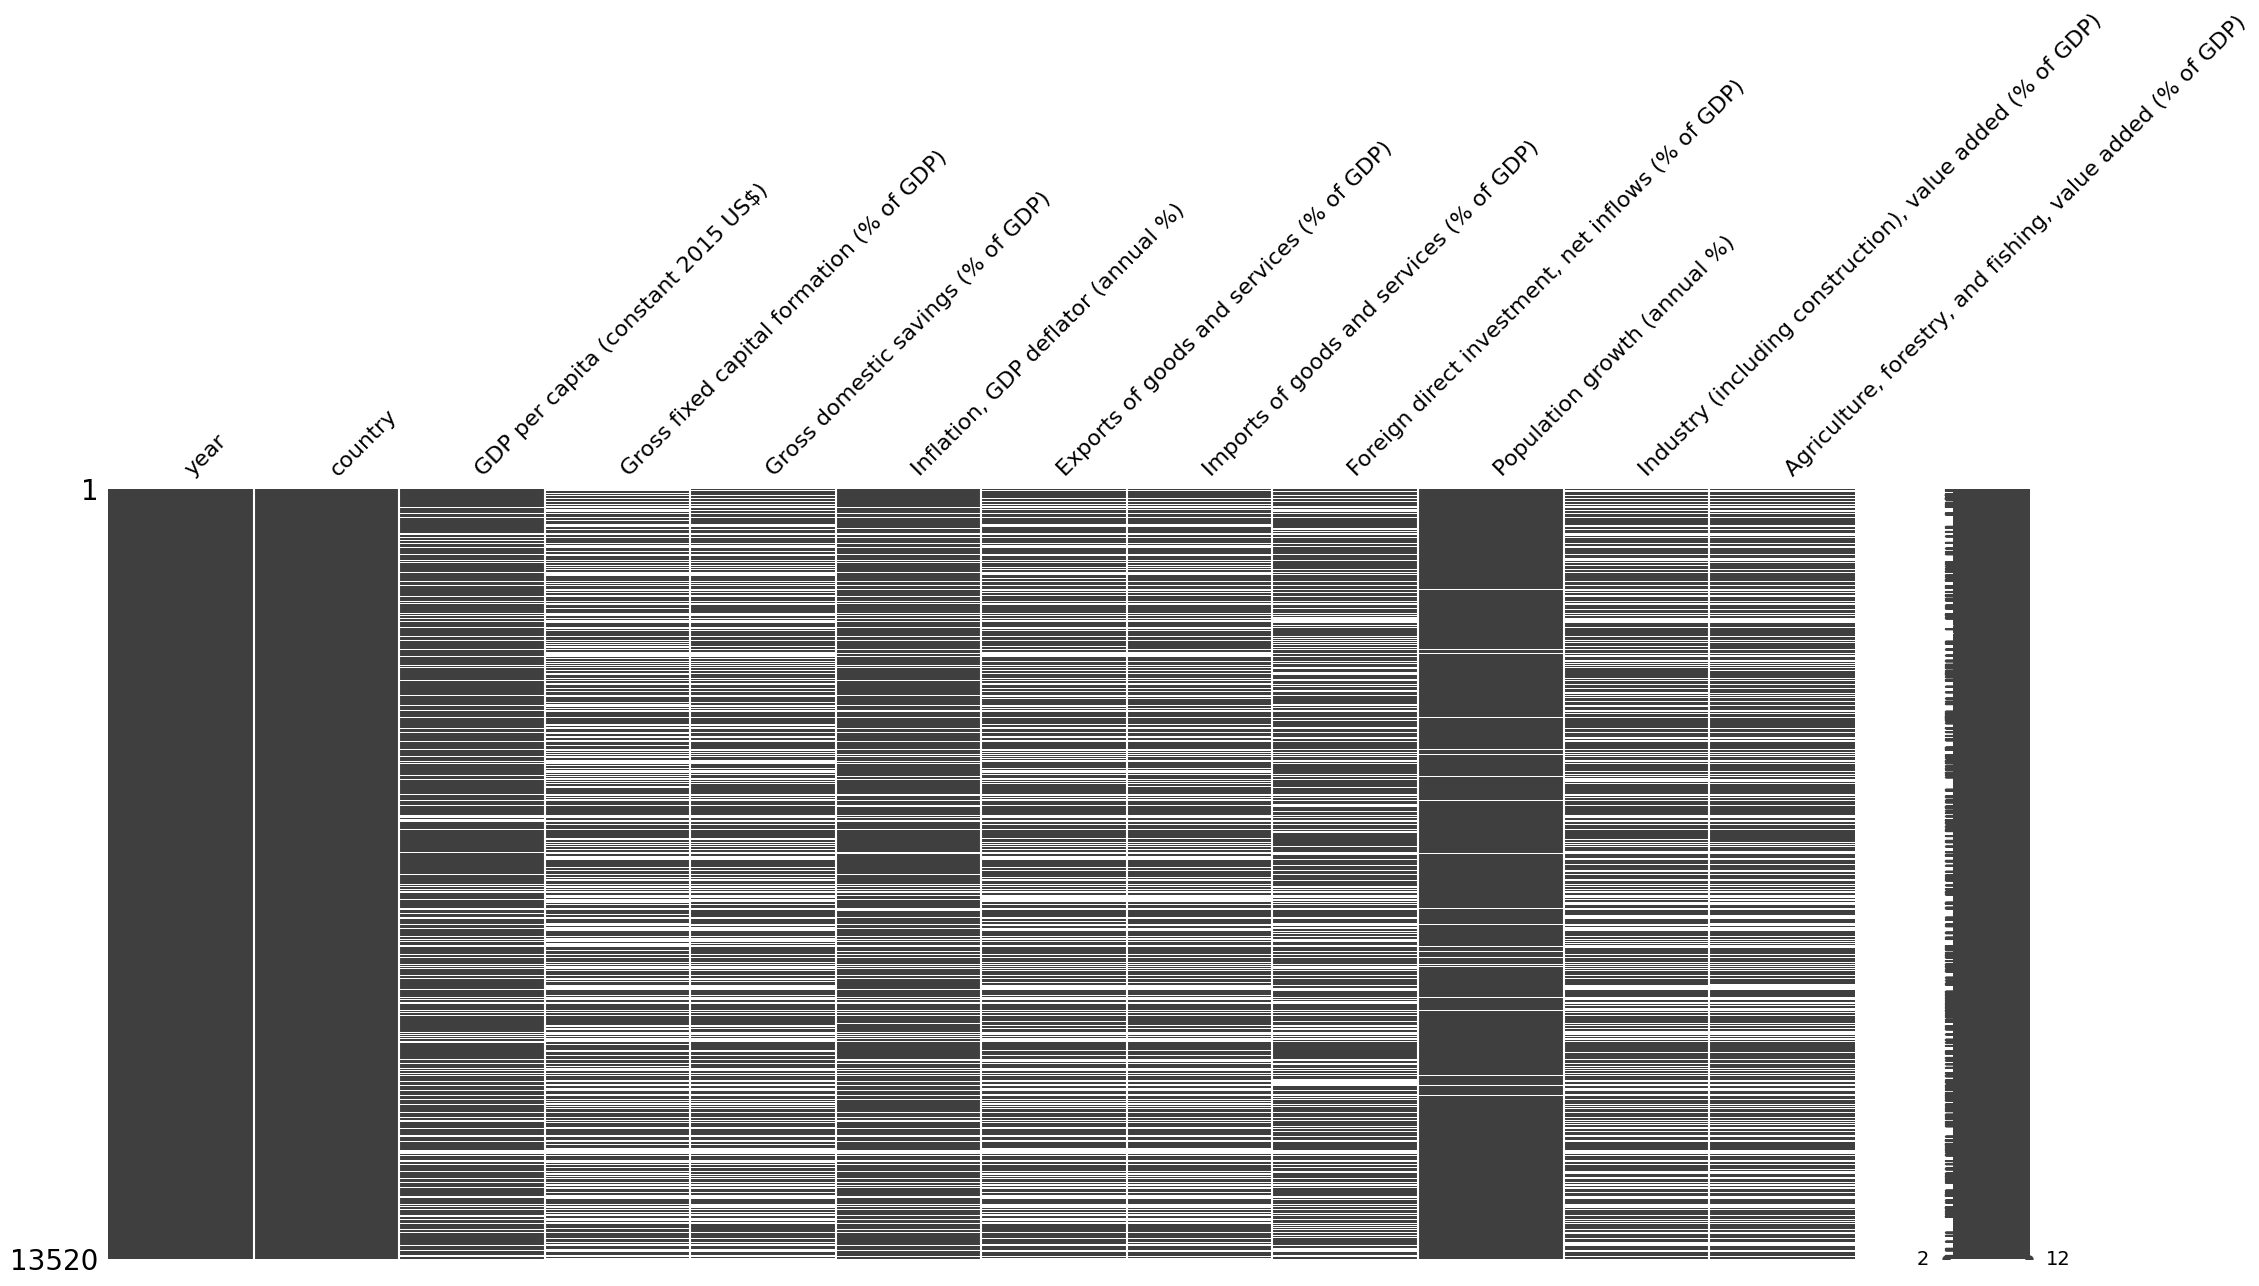

In [68]:
# Analyze missing patterns in remaining data
import missingno as msno
msno.matrix(X_train) 

### Im taking into account:

- That economic indicators are country-specific - Using country-based imputation preserves economic patterns
- That time trends matter - Linear interpolation can capture economic trends
- A fallback strategy - Global median ensures no missing values remain
- And preserves relationships - KNN imputation considers variable correlation

In [70]:
def hybrid_imputation(df):
    """Country-aware imputation with sklearn fallback"""
    from sklearn.impute import SimpleImputer
    
    df_imputed = df.copy()
    numeric_cols = df_imputed.select_dtypes(include=['float64', 'int64']).columns
    
    # Step 1: Try country-based imputation where possible
    if 'country' in df_imputed.columns:
        for col in numeric_cols:
            # Fill with country median where available
            df_imputed[col] = df_imputed.groupby('country')[col].transform(
                lambda x: x.fillna(x.median()) if x.notna().any() else x
            )
    
    # Step 2: Use sklearn for remaining missing values
    remaining_missing = df_imputed[numeric_cols].isnull().sum()
    if remaining_missing.sum() > 0:
        print(f"Using sklearn imputation for remaining {remaining_missing.sum()} missing values")
        imputer = SimpleImputer(strategy='median')
        df_imputed[numeric_cols] = imputer.fit_transform(df_imputed[numeric_cols])
    
    return df_imputed

# Use hybrid approach
X_train_imputed = hybrid_imputation(X_train)
X_test_imputed = hybrid_imputation(X_test)

Using sklearn imputation for remaining 9236 missing values
Using sklearn imputation for remaining 2594 missing values


<Axes: >

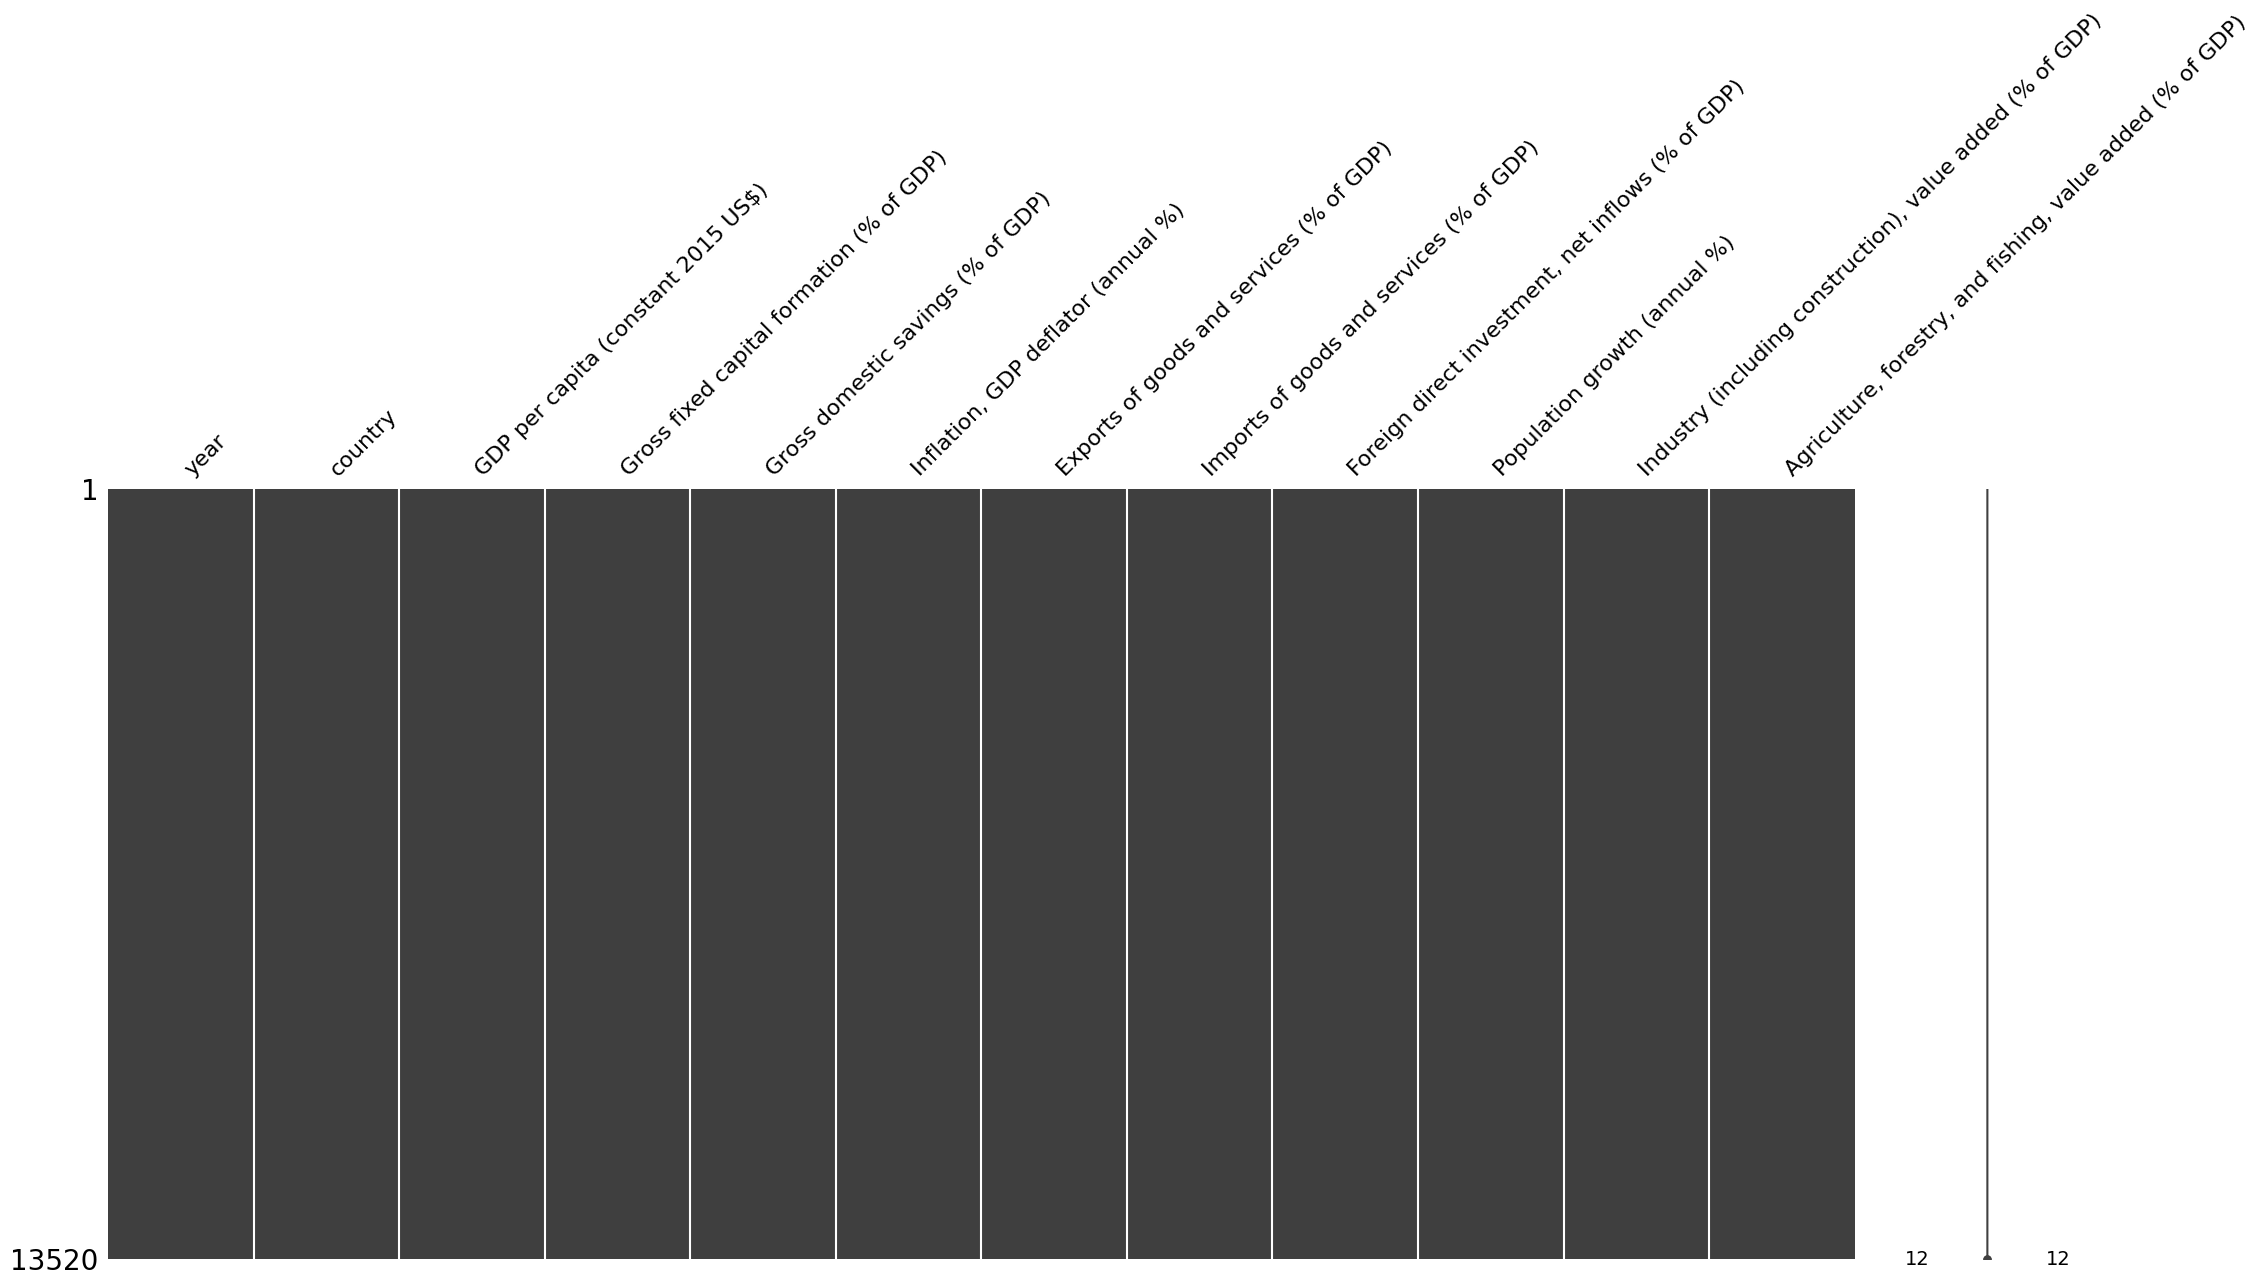

In [71]:
msno.matrix(X_train_imputed)

#All done!

<Axes: >

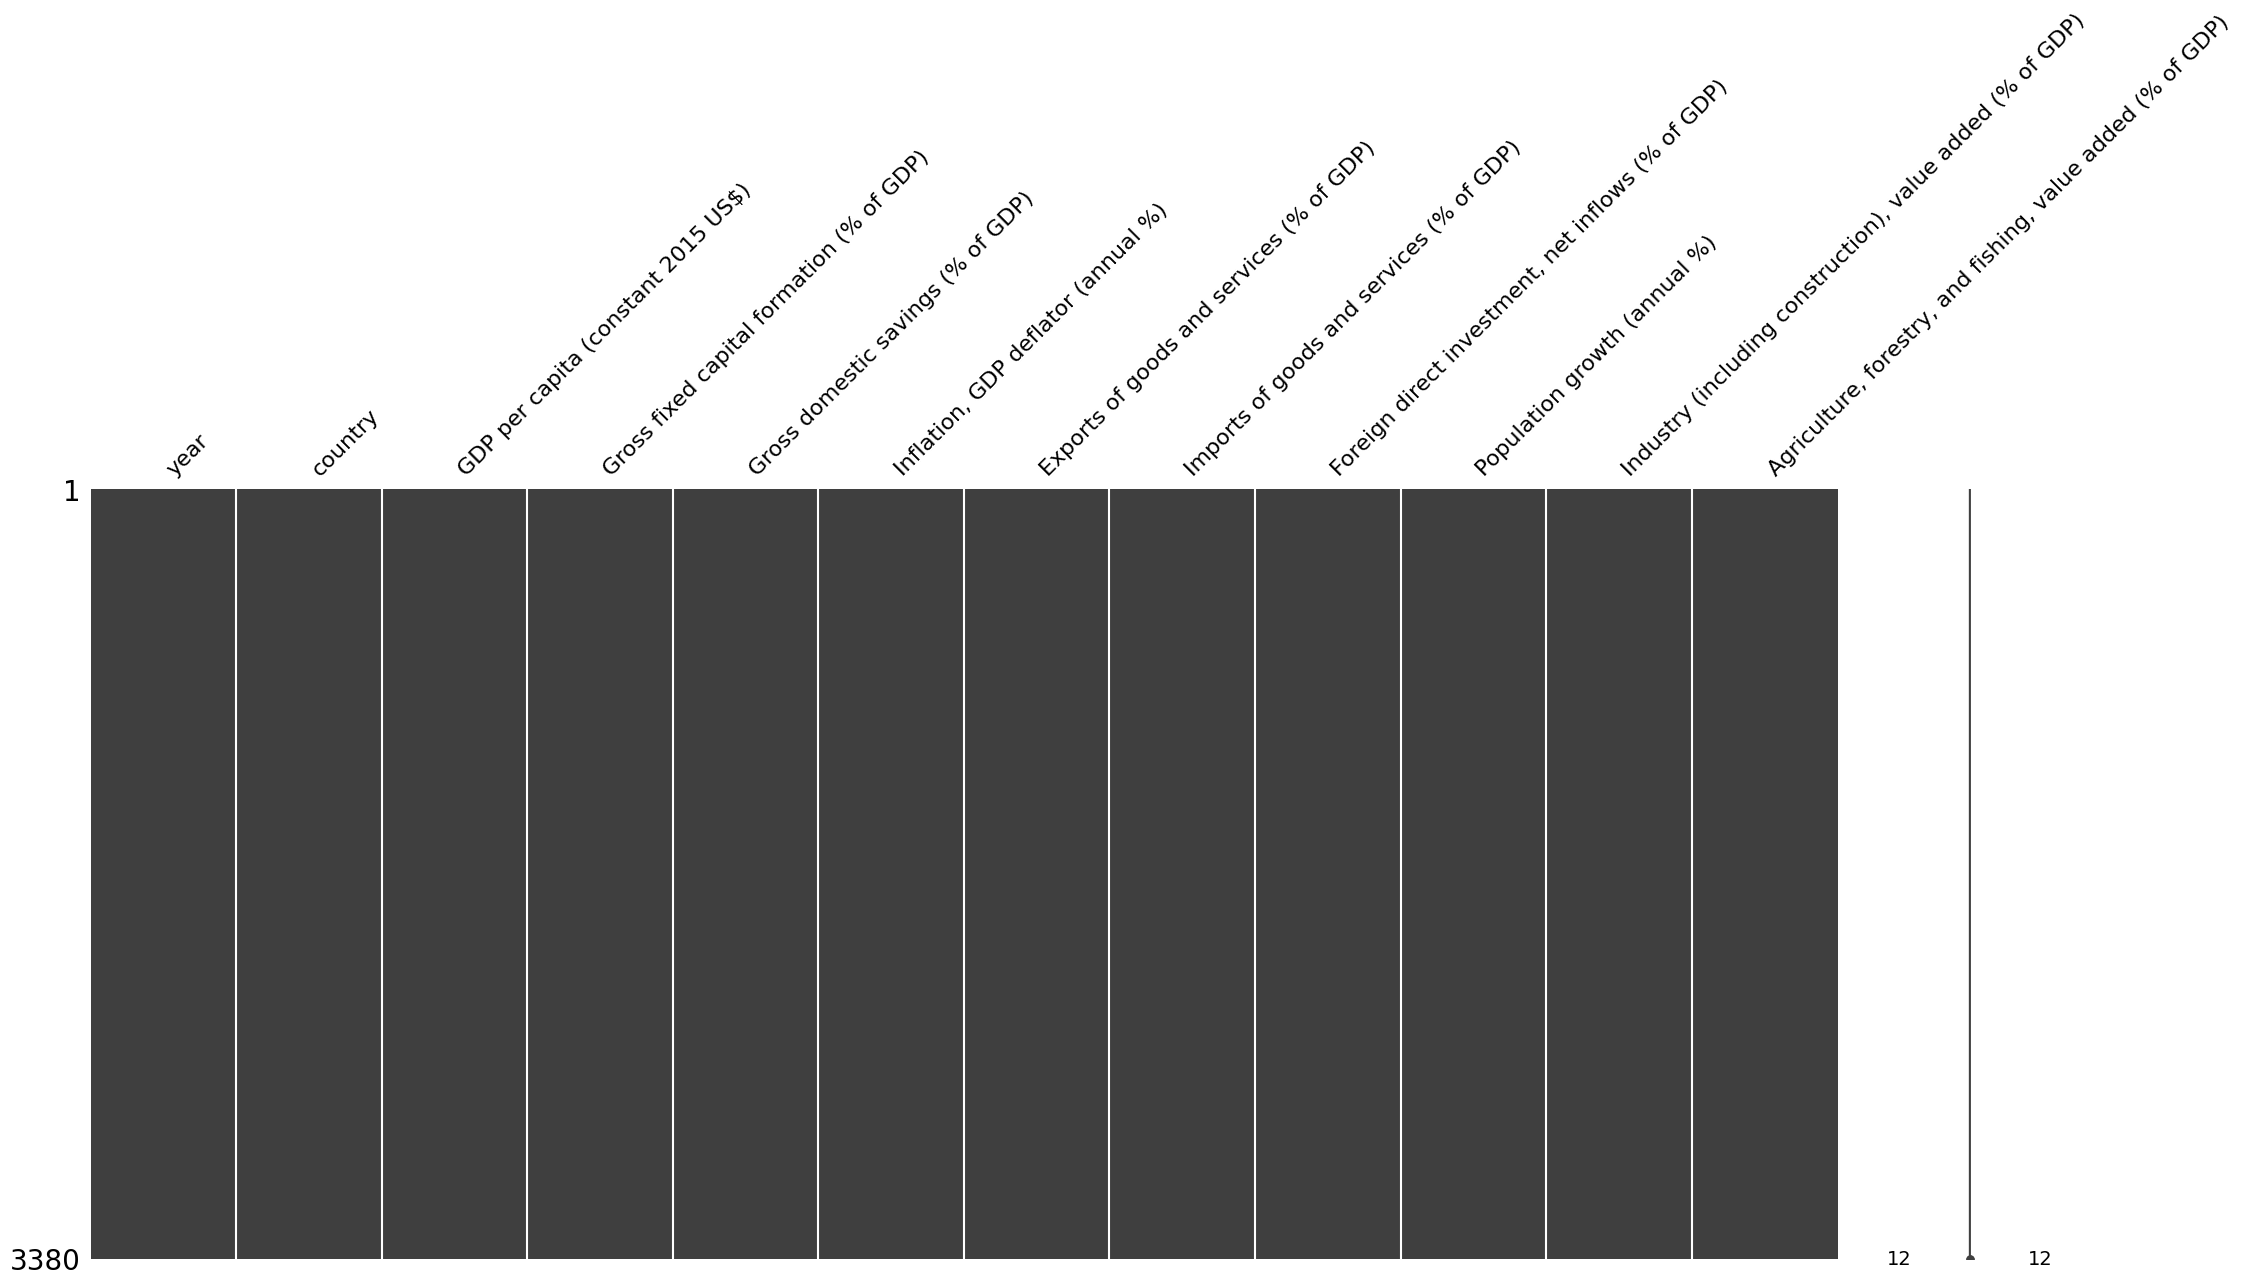

In [72]:
msno.matrix(X_test_imputed)

#All done!

# **Part 10: Anomalies, errors and outliers**
Will most likely be keeping all of my outliers in this dataset:

1. Economic crises are real events (2008 financial crisis, COVID-19)
2. Rapid growth periods (emerging economies, post-war recovery)
3. Country-specific events (oil discoveries, natural disasters)
4. Regression models can handle outliers better than classification

=== TARGET VARIABLE ANALYSIS ===
Mean: 3.67
Median: 3.81
Std: 6.23
Min: -64.05
Max: 149.97

=== OUTLIER ANALYSIS ===
Outliers (IQR method): 954 (5.6%)
Outlier bounds: [-5.79, 13.32]

=== EXTREME VALUES ===
Top 5 highest GDP growth:
      country      target
9708      GNQ  149.972963
9749      LBR  106.279814
13650     LBY   86.826748
8445      KWT   82.809329
2258      OMN   81.887797

Top 5 lowest GDP growth:
      country     target
8171      IRQ -64.047107
15742     MAC -54.336155
7929      LBR -51.030865
13390     LBY -50.338515
9039      RWA -50.248067


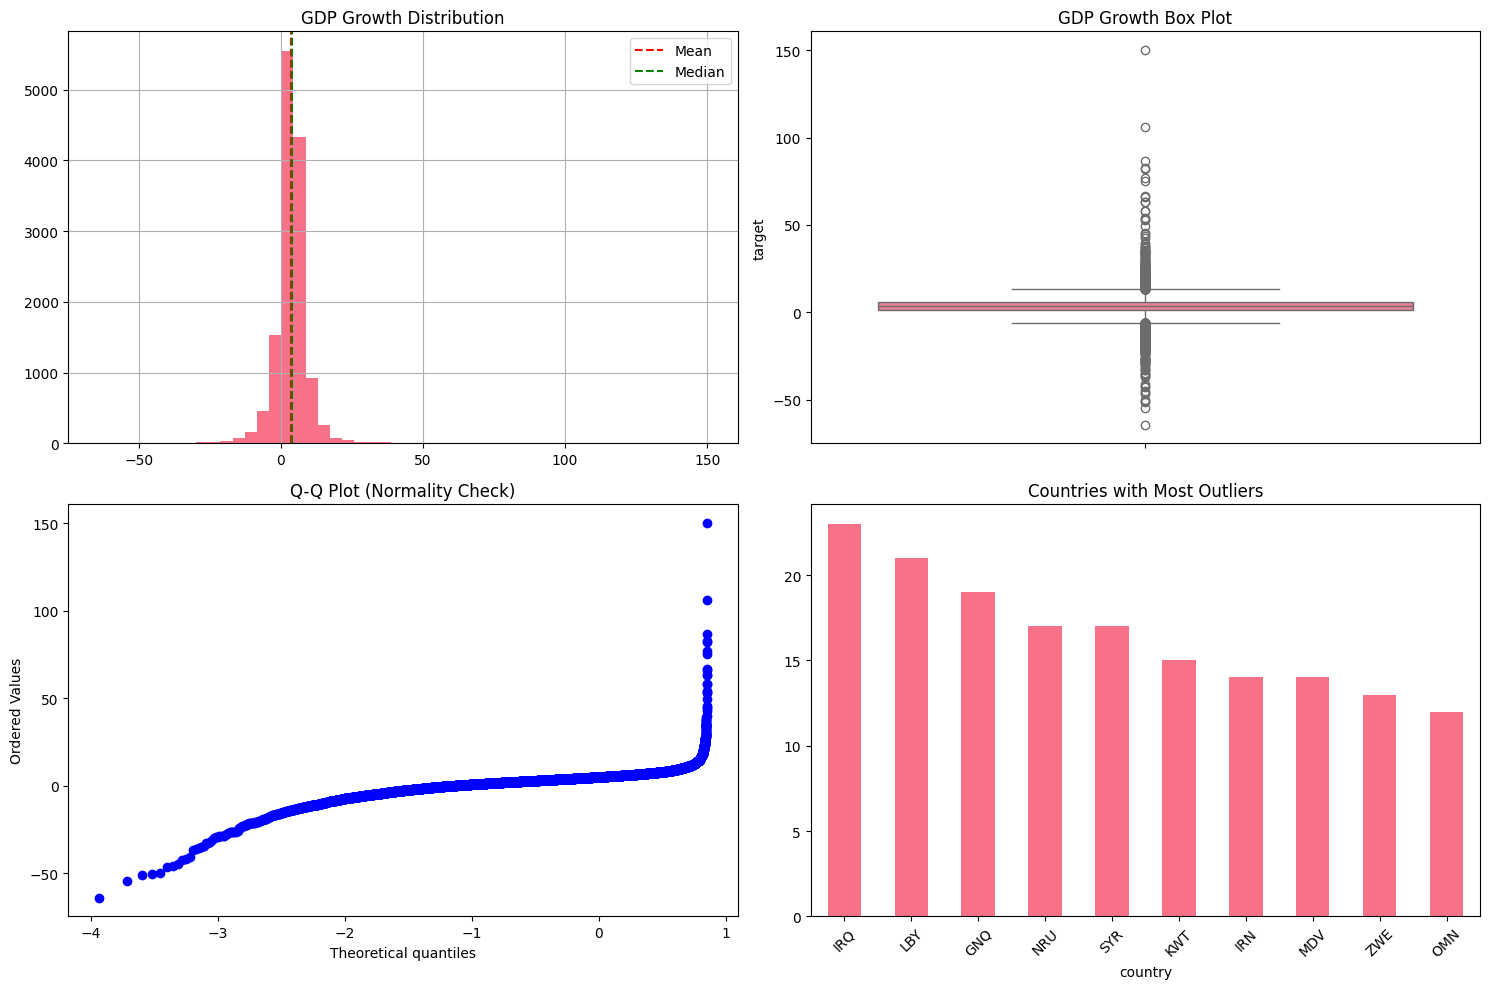

In [73]:
def analyze_outliers(df, target_col):
    """Analyze outliers without removing them"""
    
    # 1. Basic statistics
    print("=== TARGET VARIABLE ANALYSIS ===")
    print(f"Mean: {df[target_col].mean():.2f}")
    print(f"Median: {df[target_col].median():.2f}")
    print(f"Std: {df[target_col].std():.2f}")
    print(f"Min: {df[target_col].min():.2f}")
    print(f"Max: {df[target_col].max():.2f}")
    
    # 2. Identify statistical outliers (for information only)
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[target_col] < lower_bound) | (df[target_col] > upper_bound)]
    print(f"\n=== OUTLIER ANALYSIS ===")
    print(f"Outliers (IQR method): {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")
    print(f"Outlier bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    
    # 3. Show extreme cases
    print(f"\n=== EXTREME VALUES ===")
    print("Top 5 highest GDP growth:")
    print(df.nlargest(5, target_col)[['country', target_col]])
    print("\nTop 5 lowest GDP growth:")
    print(df.nsmallest(5, target_col)[['country', target_col]])
    
    # 4. Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Histogram
    df[target_col].hist(bins=50, ax=axes[0,0])
    axes[0,0].set_title('GDP Growth Distribution')
    axes[0,0].axvline(df[target_col].mean(), color='red', linestyle='--', label='Mean')
    axes[0,0].axvline(df[target_col].median(), color='green', linestyle='--', label='Median')
    axes[0,0].legend()
    
    # Box plot
    sns.boxplot(y=df[target_col], ax=axes[0,1])
    axes[0,1].set_title('GDP Growth Box Plot')
    
    # Q-Q plot to check normality
    from scipy import stats
    stats.probplot(df[target_col], dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Q-Q Plot (Normality Check)')
    
    # Outliers by country (if you have country column)
    if 'country' in df.columns:
        outlier_countries = outliers['country'].value_counts().head(10)
        outlier_countries.plot(kind='bar', ax=axes[1,1])
        axes[1,1].set_title('Countries with Most Outliers')
        axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return outliers

# Analyze your data
outliers_df = analyze_outliers(df, 'target')

# **Part 11: Feature engineering**

### RobustScaler is best for economic data because:

    1. Uses median instead of mean (less sensitive to outliers)

    2. Uses IQR instead of standard deviation

    3. Economic data often has outliers (crises, booms)

In [74]:
print("Number of unique countries:", X_train['country'].nunique())
print("Countries with most data points:")
print(X_train['country'].value_counts().head(10))
print("\nCountries with least data points:")
print(X_train['country'].value_counts().tail(5))

Number of unique countries: 260
Countries with most data points:
country
JOR    59
IMN    59
PSE    58
NIC    58
SGP    58
PRE    58
KOR    58
TSS    58
CHE    58
SVK    58
Name: count, dtype: int64

Countries with least data points:
country
COG    44
PRT    43
TON    42
FIN    42
BRN    38
Name: count, dtype: int64


In [75]:
print(X_train_imputed.shape)
print(y_train.shape)

(13520, 12)
(13520,)


In [76]:
print(X_train_imputed.isna().sum().sum())
print(X_test_imputed.isna().sum().sum())

0
0


In [79]:
print(y_train.isna().sum().sum())
print(y_test.isna().sum().sum())

2674
651


In [80]:
#Since I do have NaN on y_test and y_train, I will use a mask
mask = y_train.notna()
X_train_imputed = X_train_imputed[mask]
y_train = y_train[mask]

In [81]:
X_test_imputed = X_test_imputed.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [82]:
mask = y_test.notna()
X_test_imputed = X_test_imputed[mask]
y_test = y_test[mask]

In [85]:
#Use this to create a pipeline preprocessor and test out models
def create_preprocessing_pipelines(X_train, X_test):
    """Create separate pipelines for different model types"""
    
    # Identify column types
    numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Remove 'country' from numeric if it exists there
    if 'country' in numeric_cols:
        numeric_cols.remove('country')
    
    # For LINEAR REGRESSION (needs scaling + encoding)
    preprocessor_scaled = ColumnTransformer(
        transformers=[
            ('num', RobustScaler(), numeric_cols),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['country'])
        ],
        remainder='drop'
    )
    
    # For TREE MODELS (no scaling, but still encode country)
    preprocessor_unscaled = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_cols),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['country'])
        ],
        remainder='drop'
    )
    
    return preprocessor_scaled, preprocessor_unscaled

def create_tree_friendly_preprocessing(X_train, X_test):
    """Label encode countries for tree models (more efficient)"""
    
    X_train_processed = X_train.copy()
    X_test_processed = X_test.copy()
    
    # Label encode country
    le = LabelEncoder()
    X_train_processed['country_encoded'] = le.fit_transform(X_train_processed['country'])
    
    # Handle unknown countries in test set
    X_test_processed['country_encoded'] = X_test_processed['country'].map(
        dict(zip(le.classes_, le.transform(le.classes_)))
    ).fillna(-1)  # Unknown country = -1
    
    # Drop original country column
    X_train_processed = X_train_processed.drop('country', axis=1)
    X_test_processed = X_test_processed.drop('country', axis=1)
    
    return X_train_processed, X_test_processed, le

def compare_all_models(X_train, X_test, y_train, y_test):
    """Compare all models with appropriate preprocessing"""
    
    results = {}
    
    # 1. LINEAR REGRESSION (with scaling + one-hot encoding)
    numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
    if 'country' in numeric_cols:
        numeric_cols.remove('country')
    
    linear_pipeline = Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', RobustScaler(), numeric_cols),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['country'])
        ])),
        ('model', LinearRegression())
    ])
    
    # 2. TREE MODELS (no scaling + label encoding)
    # Prepare data for tree models
    X_train_trees, X_test_trees, country_encoder = create_tree_friendly_preprocessing(X_train, X_test)  # Fixed typo
    
    tree_models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    # Evaluate Linear Regression
    lr_scores = cross_val_score(linear_pipeline, X_train, y_train, cv=5, scoring='r2')
    results['Linear Regression'] = {
        'CV Score': lr_scores.mean(),
        'CV Std': lr_scores.std(),
        'Pipeline': linear_pipeline
    }
    
    # Evaluate Tree Models
    for name, model in tree_models.items():
        scores = cross_val_score(model, X_train_trees, y_train, cv=5, scoring='r2')
        results[name] = {
            'CV Score': scores.mean(),
            'CV Std': scores.std(),
            'Pipeline': model,
            'Preprocessed_Data': (X_train_trees, X_test_trees),  # Store for later use
            'Country_Encoder': country_encoder
        }
    
    return results

# Usage:
# Create pipelines (if you want to use the pipeline approach)
preprocessor_scaled, preprocessor_unscaled = create_preprocessing_pipelines(X_train_imputed, X_test_imputed)

# Create all model pipelines (alternative approach)
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor_scaled),
        ('model', LinearRegression())
    ]),
    
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor_unscaled),
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor_unscaled),
        ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
}

# For tree models - more efficient approach
X_train_trees, X_test_trees, country_encoder = create_tree_friendly_preprocessing(
    X_train_imputed, X_test_imputed
)

# Run comparison
model_results = compare_all_models(X_train_imputed, X_test_imputed, y_train, y_test)

# Display results
print("=== MODEL COMPARISON ===")
for model_name, metrics in model_results.items():
    print(f"{model_name}: R² = {metrics['CV Score']:.3f} (+/- {metrics['CV Std']*2:.3f})")

# Optional: Test both approaches to see if there's a difference
print("\n=== PIPELINE APPROACH COMPARISON ===")
for name, pipeline in models.items():
    if 'Linear' in name:
        scores = cross_val_score(pipeline, X_train_imputed, y_train, cv=5, scoring='r2')
    else:
        scores = cross_val_score(pipeline, X_train_imputed, y_train, cv=5, scoring='r2')
    print(f"{name}: R² = {scores.mean():.3f} (+/- {scores.std()*2:.3f})")

=== MODEL COMPARISON ===
Linear Regression: R² = 0.064 (+/- 0.023)
Random Forest: R² = 0.243 (+/- 0.088)
Gradient Boosting: R² = 0.167 (+/- 0.088)

=== PIPELINE APPROACH COMPARISON ===
Linear Regression: R² = 0.064 (+/- 0.023)
Random Forest: R² = 0.234 (+/- 0.098)
Gradient Boosting: R² = 0.167 (+/- 0.083)


In [87]:
# After fitting Random Forest, check country importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_trees, y_train)

# Get feature importance
feature_names = X_train_trees.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

Top 10 Most Important Features:
                                              feature  importance
4                  Inflation, GDP deflator (annual %)    0.152395
8                        Population growth (annual %)    0.137644
0                                                year    0.120673
7   Foreign direct investment, net inflows (% of GDP)    0.104404
9   Industry (including construction), value added...    0.086742
3                   Gross domestic savings (% of GDP)    0.072404
1                  GDP per capita (constant 2015 US$)    0.072396
2            Gross fixed capital formation (% of GDP)    0.063757
10  Agriculture, forestry, and fishing, value adde...    0.054970
6            Imports of goods and services (% of GDP)    0.052723


In [ ]:
#Not too much different  between pipeline and models, Random Forest seems the best one in terms of R2, we will go ahead and try the rest of the models
#Interestin to see feature importance in Random Forest

In [86]:
X_train_trees, X_test_trees, _ = create_tree_friendly_preprocessing(X_train_imputed, X_test_imputed)
print(f"Training set: {X_train_imputed.shape}")
print(f"Test set: {X_test_imputed.shape}")

Training set: (10846, 12)
Test set: (2729, 12)


# **Part 12: Model testing**

In [88]:
#Making sure X_trees columns match X_train
X_test_trees = X_test_trees[X_train_trees.columns]
print(X_train_trees.columns.equals(X_test_trees.columns))

True


In [89]:
#Model 1: Random Forest

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_trees, y_train)
y_pred = model.predict(X_test_trees[X_train_trees.columns])  # Ensure column match

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

RMSE: 5.87
MAE: 3.07
R²: 0.145


In [90]:
# Model 2:  Gradient Boosting
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_model.fit(X_train_trees, y_train)

# Ensure test set has same columns
y_pred_gbr = gbr_model.predict(X_test_trees[X_train_trees.columns])

# Evaluate
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("=== Gradient Boosting Performance ===")
print(f"RMSE: {rmse_gbr:.2f}")
print(f"MAE: {mae_gbr:.2f}")
print(f"R²: {r2_gbr:.3f}")

=== Gradient Boosting Performance ===
RMSE: 5.95
MAE: 3.37
R²: 0.122


In [91]:
# Model 3: Linear Regression
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor_scaled),
    ('model', LinearRegression())
])
linear_pipeline.fit(X_train_imputed, y_train)

# Predict on test data
y_pred_lr = linear_pipeline.predict(X_test_imputed)

# Evaluate
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("=== Linear Regression Test Performance ===")
print(f"RMSE: {rmse_lr:.2f}")
print(f"MAE: {mae_lr:.2f}")
print(f"R²: {r2_lr:.3f}")

=== Linear Regression Test Performance ===
RMSE: 6.18
MAE: 3.50
R²: 0.053


In [92]:
from sklearn.linear_model import ElasticNet

# Model 4: ElasticNet
elastic_pipeline = Pipeline([
    ('preprocessor', preprocessor_scaled),
    ('model', ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42))
])
elastic_pipeline.fit(X_train_imputed, y_train)

# Predict
y_pred_en = elastic_pipeline.predict(X_test_imputed)

# Evaluate
rmse_en = np.sqrt(mean_squared_error(y_test, y_pred_en))
mae_en = mean_absolute_error(y_test, y_pred_en)
r2_en = r2_score(y_test, y_pred_en)
mape_en = np.mean(np.abs((y_test - y_pred_en) / y_test)) * 100

print("=== ElasticNet Test Performance ===")
print(f"RMSE: {rmse_en:.2f}")
print(f"MAE: {mae_en:.2f}")
print(f"R²: {r2_en:.3f}")
print(f"MAPE: {mape_en:.2f}%")

=== ElasticNet Test Performance ===
RMSE: 6.27
MAE: 3.63
R²: 0.026
MAPE: inf%


In [93]:
from lightgbm import LGBMRegressor

# Model 5:  LightGBM
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor_scaled),
    ('model', LGBMRegressor(n_estimators=100, random_state=42))
])
lgbm_pipeline.fit(X_train_imputed, y_train)

# Predict
y_pred_lgb = lgbm_pipeline.predict(X_test_imputed)

# Evaluate
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)
mape_lgb = np.mean(np.abs((y_test - y_pred_lgb) / y_test)) * 100

print("=== LightGBM Test Performance ===")
print(f"RMSE: {rmse_lgb:.2f}")
print(f"MAE: {mae_lgb:.2f}")
print(f"R²: {r2_lgb:.3f}")
print(f"MAPE: {mape_lgb:.2f}%");

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3093
[LightGBM] [Info] Number of data points in the train set: 10846, number of used features: 251
[LightGBM] [Info] Start training from score 3.726895
=== LightGBM Test Performance ===
RMSE: 5.78
MAE: 3.11
R²: 0.171
MAPE: inf%


In [94]:
from xgboost import XGBRegressor

#Model 6 : XGBoost


xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor_scaled),
    ('model', XGBRegressor(n_estimators=100, random_state=42, verbosity=0))
])
xgb_pipeline.fit(X_train_imputed, y_train)

# Predict
y_pred_xgb = xgb_pipeline.predict(X_test_imputed)

# Evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

print("=== XGBoost Test Performance ===")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"R²: {r2_xgb:.3f}")
print(f"MAPE: {mape_xgb:.2f}%")

=== XGBoost Test Performance ===
RMSE: 5.92
MAE: 3.14
R²: 0.131
MAPE: inf%


#### After trying out this 6 models, I will choose LightGBM for the RMSE of 5.78, I care about accurately capturing volatile economic events and RMSE penalizes larger errors more heavily. R2 is also a good barometer because  its helping me see how well my model explains the variation in GDP growth across all conditions.

# **Part 13: LightGBM optimization**

#### This will be done with RandomSearch

In [95]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor, early_stopping
import numpy as np
import scipy.stats as stats
from sklearn.metrics import mean_absolute_percentage_error

⚡ Starting RMSE-optimized search...
📊 Total combinations to test: 30
🔄 Cross-validation folds: 3
🚀 Optimized for speed while maintaining effectiveness...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/skle


🎯==========================================================🎯
    RMSE-OPTIMIZED LIGHTGBM SEARCH RESULTS
🎯==========================================================🎯
🏆 Best CV RMSE: 5.3904
📈 CV Score Improvement: 0.4614

🔧 Best Parameters:
   subsample: 1.0
   reg_lambda: 0.5
   reg_alpha: 1.0
   num_leaves: 200
   n_estimators: 300
   min_child_samples: 10
   max_depth: -1
   learning_rate: 0.01
   colsample_bytree: 0.8

📊 Test Performance:
   🎯 RMSE: 5.7536
   📏 MAE: 3.0714
   📈 R²: 0.1787
   📊 MAPE: 1098884869128848.50%

🏋️ Train Performance:
   🎯 RMSE: 4.1268
   📈 R²: 0.5568
   ⚠️  Overfitting Check: 0.3781 R² difference

📊 Generating key RMSE visualizations...


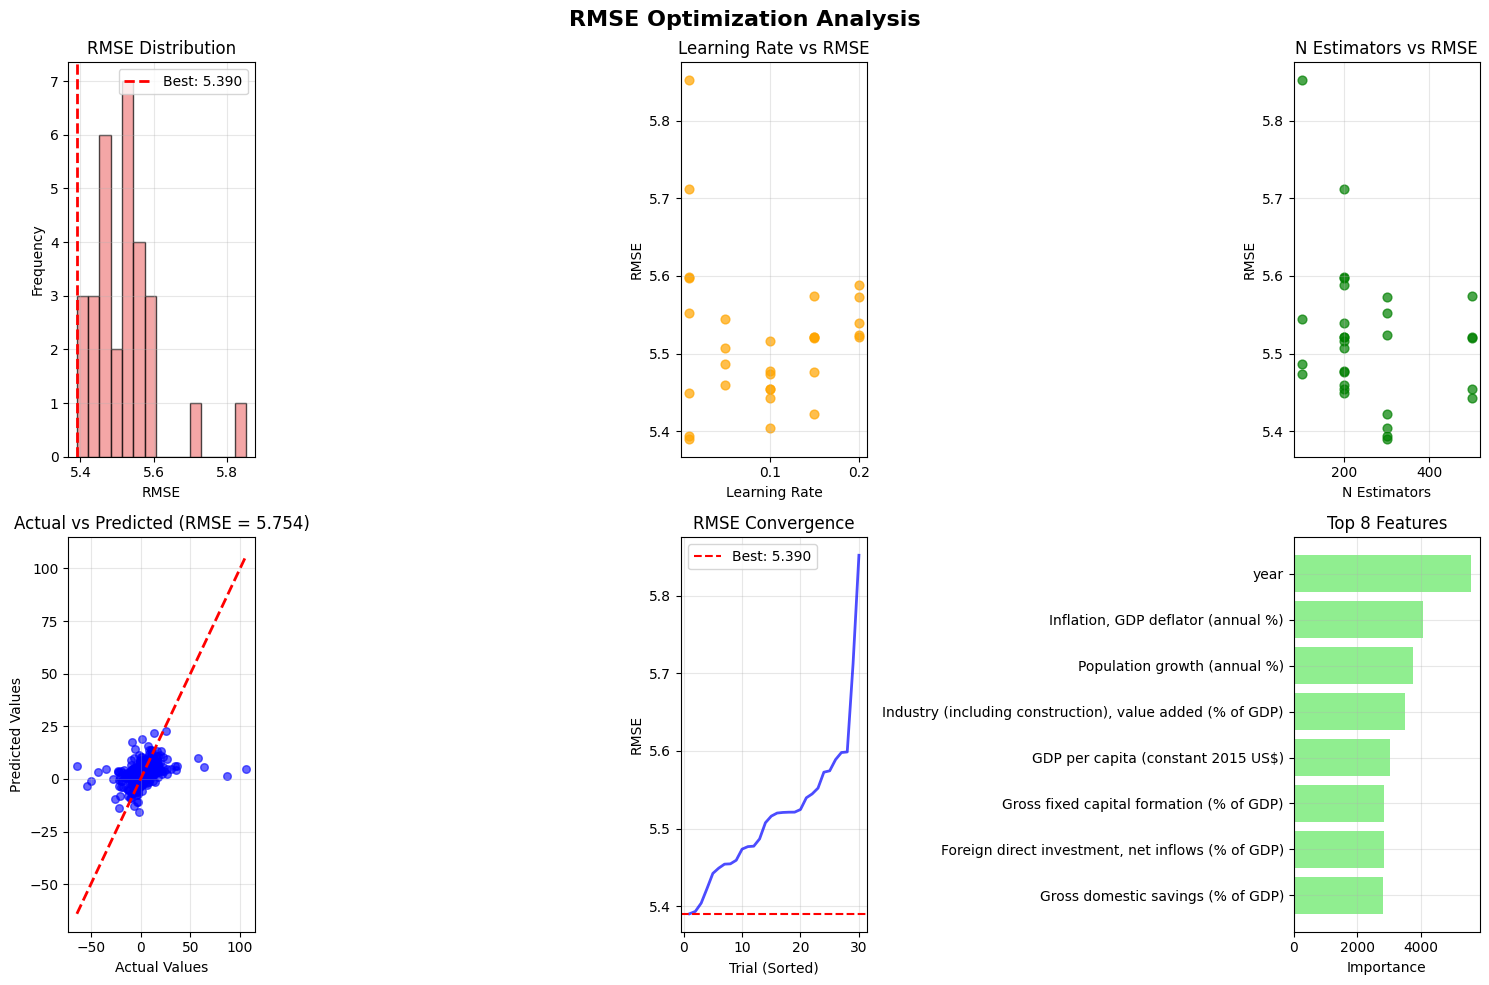


⚡ RMSE OPTIMIZATION SUMMARY:
🎯 Final Test RMSE: 5.7536
🏆 Best CV RMSE: 5.3904
🔄 Total trials: 30
📈 RMSE range: 5.3904 - 5.8519
⚠️  Overfitting detected (R² diff: 0.378)

⚡ Optimization Complete! (30 trials, 3-fold CV)


In [100]:
#Test #2: Final test
# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Define numeric and categorical columns
numeric_cols = X_train_imputed.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'country' in numeric_cols:
    numeric_cols.remove('country')

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['country'])
    ]
)

# Full pipeline with LightGBM
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=42, verbose=-1))
])

# FAST hyperparameter distributions for RMSE reduction
param_dist = {
    # Core parameters - focused ranges for speed
    'model__n_estimators': [100, 200, 300, 500],  # Discrete values for speed
    'model__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],  # Discrete values
    'model__num_leaves': [31, 50, 100, 150, 200],  # Key values only
    'model__max_depth': [-1, 5, 10, 15],  # Reduced options
    
    # Key regularization parameters
    'model__min_child_samples': [10, 20, 30, 50],  # Discrete values
    'model__subsample': [0.7, 0.8, 0.9, 1.0],  # Key values
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Key values
    
    # Essential regularization
    'model__reg_alpha': [0, 0.1, 0.5, 1.0],  # Discrete values
    'model__reg_lambda': [0, 0.1, 0.5, 1.0],  # Discrete values
}

# FAST randomized search - optimized for speed
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,  # Reduced for speed
    cv=3,  # Reduced CV folds for speed
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

print("⚡ Starting RMSE-optimized search...")
print(f"📊 Total combinations to test: {random_search.n_iter}")
print(f"🔄 Cross-validation folds: {random_search.cv}")
print("🚀 Optimized for speed while maintaining effectiveness...")

# Fit preprocessor separately to transform X_test for early stopping
preprocessor.fit(X_train_imputed)
X_test_processed = preprocessor.transform(X_test_imputed)

# Fit the model with enhanced early stopping for RMSE
random_search.fit(
    X_train_imputed,
    y_train,
    model__eval_set=[(X_test_processed, y_test)],
    model__eval_metric='rmse',
    model__callbacks=[early_stopping(stopping_rounds=10, verbose=False)]  # Faster stopping
)

# Get best model and predict
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_imputed)
y_train_pred = best_model.predict(X_train_imputed)

# Calculate comprehensive metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

# Enhanced reporting
print("\n" + "🎯" + "="*58 + "🎯")
print("    RMSE-OPTIMIZED LIGHTGBM SEARCH RESULTS")
print("🎯" + "="*58 + "🎯")
print(f"🏆 Best CV RMSE: {-random_search.best_score_:.4f}")
print(f"📈 CV Score Improvement: {(random_search.cv_results_['mean_test_score'].max() - random_search.cv_results_['mean_test_score'].min()):.4f}")

print(f"\n🔧 Best Parameters:")
for param, value in random_search.best_params_.items():
    print(f"   {param.replace('model__', '')}: {value}")

print(f"\n📊 Test Performance:")
print(f"   🎯 RMSE: {rmse:.4f}")
print(f"   📏 MAE: {mae:.4f}")
print(f"   📈 R²: {r2:.4f}")
print(f"   📊 MAPE: {mape*100:.2f}%")

print(f"\n🏋️ Train Performance:")
print(f"   🎯 RMSE: {rmse_train:.4f}")
print(f"   📈 R²: {r2_train:.4f}")
print(f"   ⚠️  Overfitting Check: {(r2_train - r2):.4f} R² difference")

# STREAMLINED visualization for speed
print("\n📊 Generating key RMSE visualizations...")

# Create focused results analysis
results_df = pd.DataFrame(random_search.cv_results_)
results_df['rmse_score'] = -results_df['mean_test_score']

# Create focused visualization - 6 key plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('RMSE Optimization Analysis', fontsize=16, fontweight='bold')

# 1. RMSE Distribution
ax = axes[0, 0]
ax.hist(results_df['rmse_score'], bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
ax.axvline(-random_search.best_score_, color='red', linestyle='--', linewidth=2,
           label=f'Best: {-random_search.best_score_:.3f}')
ax.set_xlabel('RMSE')
ax.set_ylabel('Frequency')
ax.set_title('RMSE Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Learning Rate vs RMSE
ax = axes[0, 1]
ax.scatter(results_df['param_model__learning_rate'], results_df['rmse_score'], 
           alpha=0.7, c='orange', s=40)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('RMSE')
ax.set_title('Learning Rate vs RMSE')
ax.grid(True, alpha=0.3)

# 3. N Estimators vs RMSE
ax = axes[0, 2]
ax.scatter(results_df['param_model__n_estimators'], results_df['rmse_score'], 
           alpha=0.7, c='green', s=40)
ax.set_xlabel('N Estimators')
ax.set_ylabel('RMSE')
ax.set_title('N Estimators vs RMSE')
ax.grid(True, alpha=0.3)

# 4. Actual vs Predicted
ax = axes[1, 0]
ax.scatter(y_test, y_pred, alpha=0.6, color='blue', s=30)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title(f'Actual vs Predicted (RMSE = {rmse:.3f})')
ax.grid(True, alpha=0.3)

# 5. RMSE Convergence
ax = axes[1, 1]
sorted_rmse = sorted(results_df['rmse_score'].values)
ax.plot(range(1, len(sorted_rmse) + 1), sorted_rmse, 'b-', alpha=0.7, linewidth=2)
ax.axhline(-random_search.best_score_, color='red', linestyle='--', 
           label=f'Best: {-random_search.best_score_:.3f}')
ax.set_xlabel('Trial (Sorted)')
ax.set_ylabel('RMSE')
ax.set_title('RMSE Convergence')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Feature Importance (Top 8)
ax = axes[1, 2]
try:
    feature_importance = best_model.named_steps['model'].feature_importances_
    feature_names = numeric_cols.copy()
    
    # Add categorical feature names
    cat_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
    if hasattr(cat_encoder, 'categories_'):
        cat_names = [f"country_{cat}" for cat in cat_encoder.categories_[0][1:]]
        feature_names.extend(cat_names)
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names[:len(feature_importance)],
        'importance': feature_importance
    }).sort_values('importance', ascending=True).tail(8)
    
    ax.barh(importance_df['feature'], importance_df['importance'], color='lightgreen')
    ax.set_xlabel('Importance')
    ax.set_title('Top 8 Features')
    ax.grid(True, alpha=0.3)
except Exception:
    ax.text(0.5, 0.5, 'Feature importance\nnot available', 
            ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Feature Importance')

plt.tight_layout()
plt.show()

# RMSE Analysis
print("\n⚡ RMSE OPTIMIZATION SUMMARY:")
print("="*40)
print(f"🎯 Final Test RMSE: {rmse:.4f}")
print(f"🏆 Best CV RMSE: {-random_search.best_score_:.4f}")
print(f"🔄 Total trials: {len(results_df)}")
print(f"📈 RMSE range: {results_df['rmse_score'].min():.4f} - {results_df['rmse_score'].max():.4f}")

# Quick overfitting check
overfitting_score = r2_train - r2
if overfitting_score > 0.1:
    print(f"⚠️  Overfitting detected (R² diff: {overfitting_score:.3f})")
else:
    print(f"✅ Good generalization (R² diff: {overfitting_score:.3f})")

print(f"\n⚡ Optimization Complete! ({random_search.n_iter} trials, {random_search.cv}-fold CV)")


Generating comprehensive visualizations...


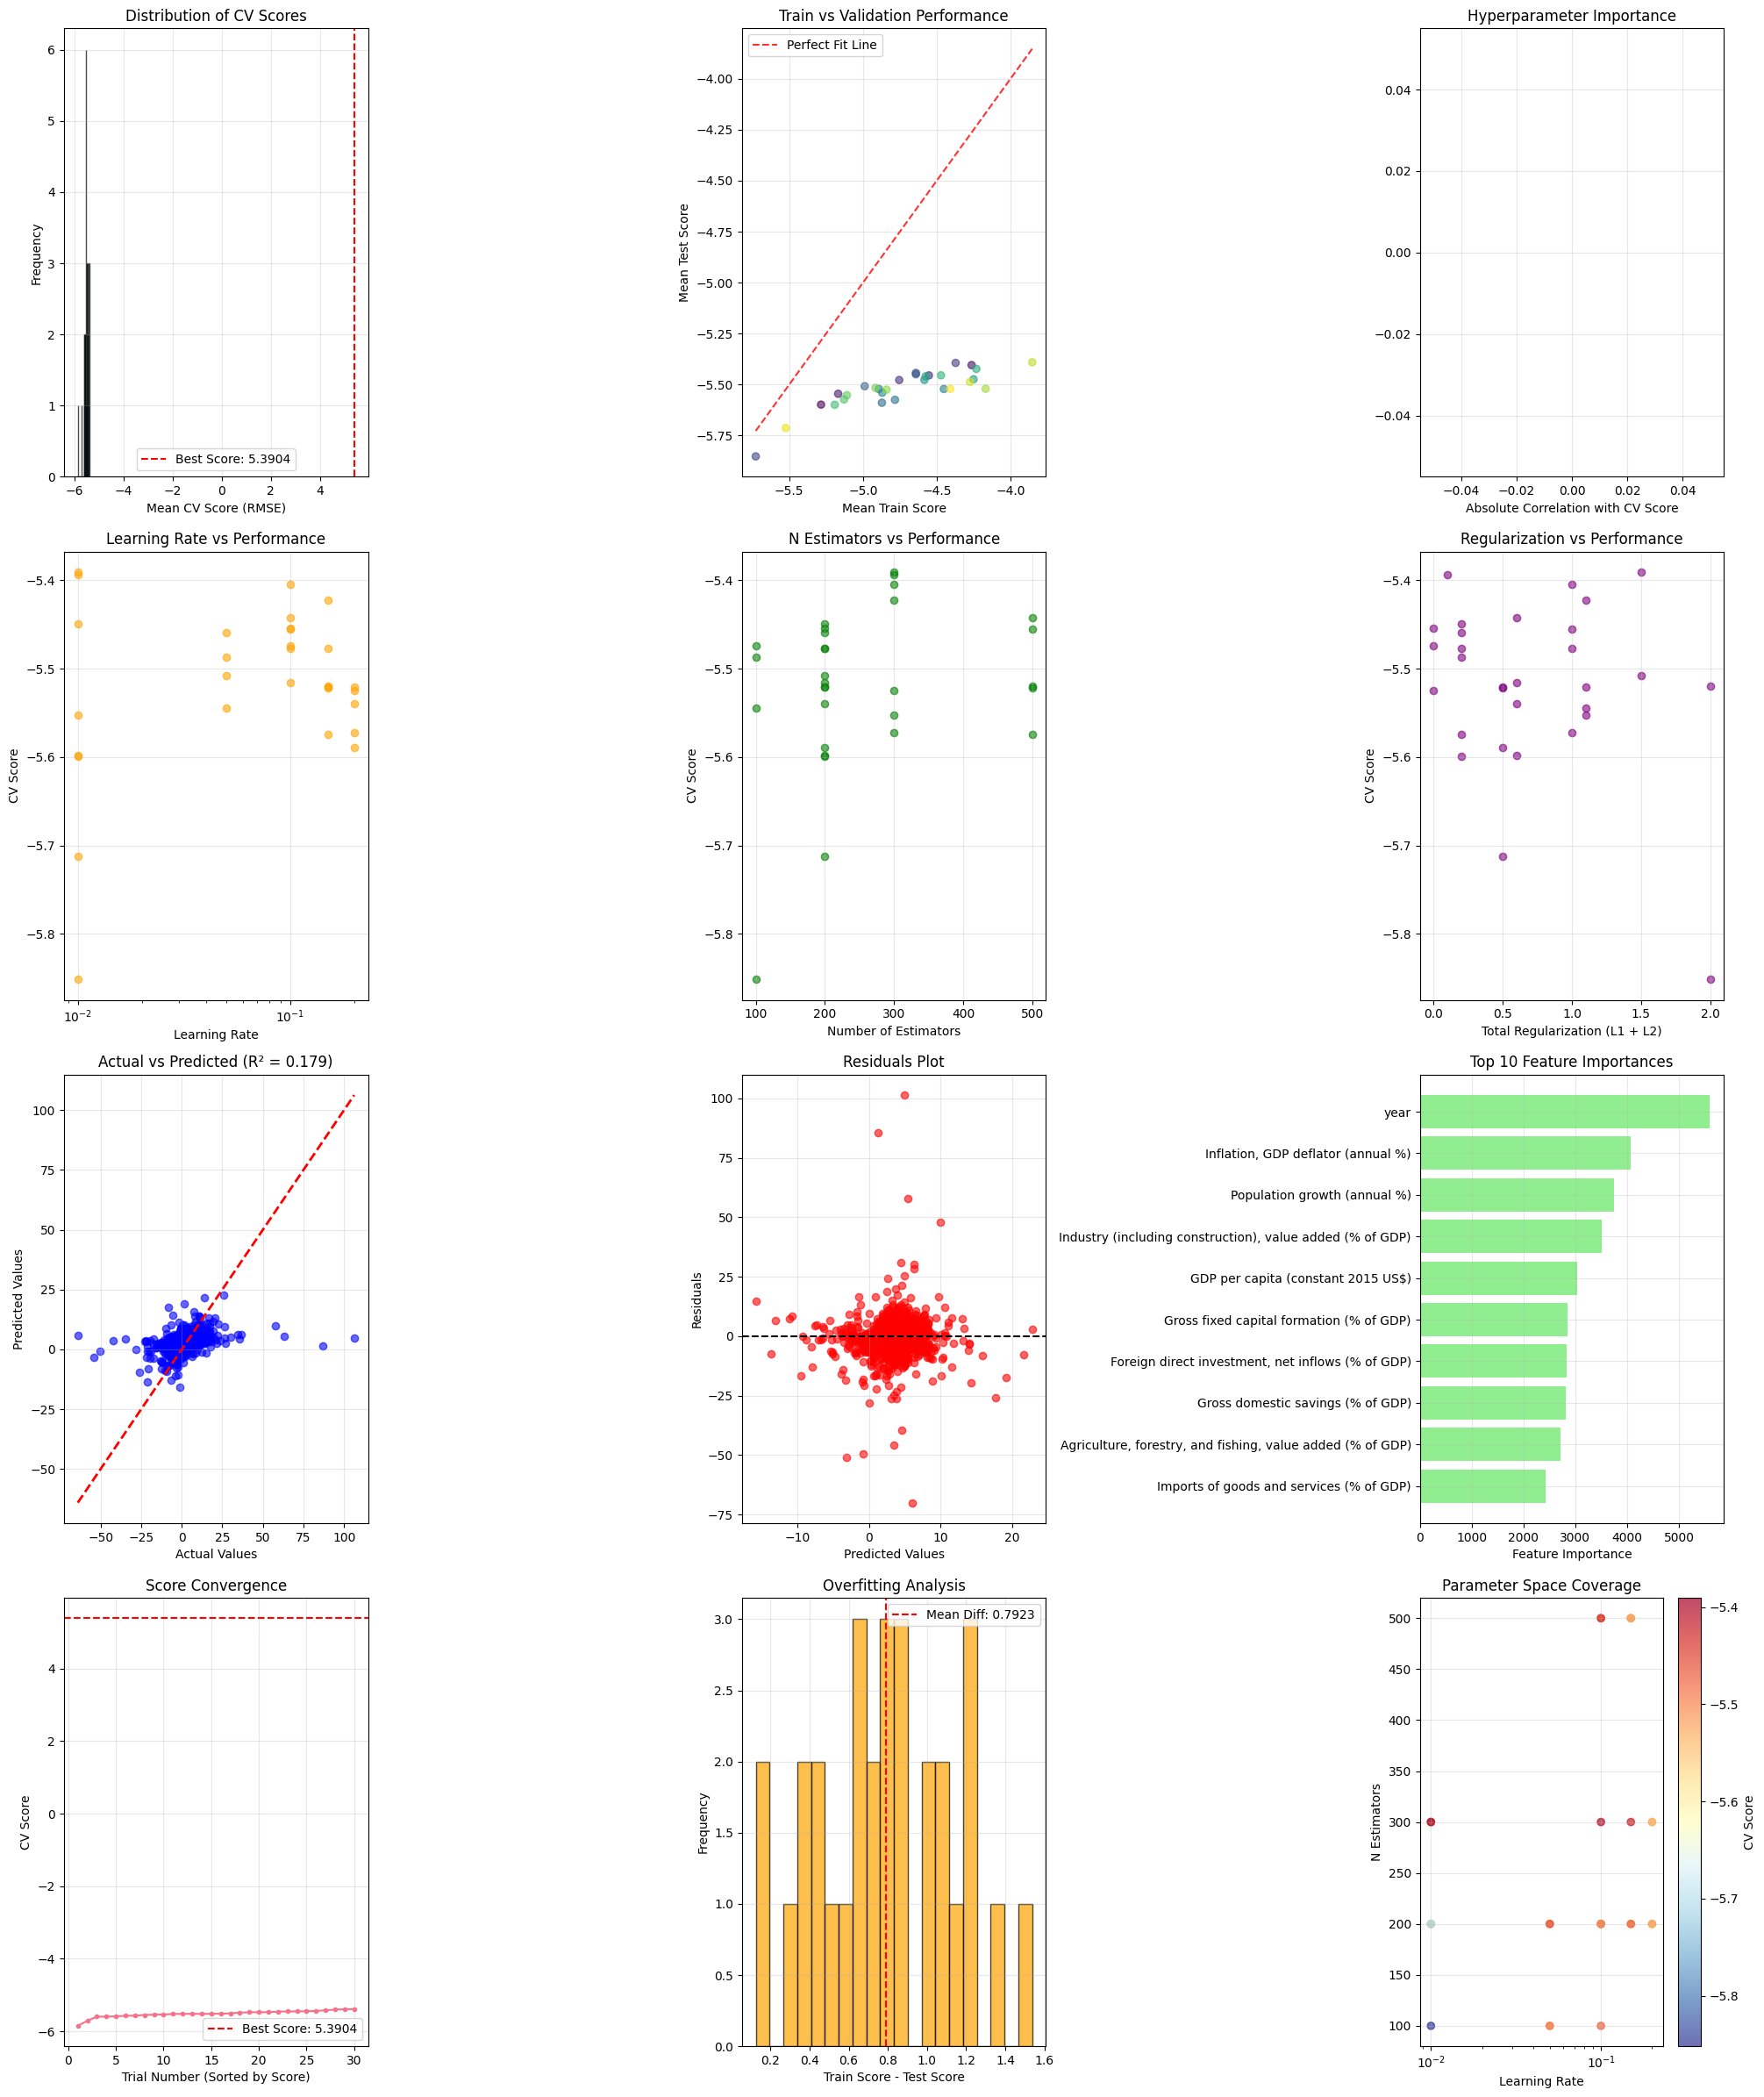

In [ ]:
# COMPREHENSIVE VISUALIZATION SECTION
print("\nGenerating comprehensive visualizations...")

# Create results DataFrame for analysis
results_df = pd.DataFrame(random_search.cv_results_)

# Set up the plotting area
fig = plt.figure(figsize=(20, 24))

# 1. CV Score Distribution
ax1 = plt.subplot(4, 3, 1)
plt.hist(results_df['mean_test_score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(-random_search.best_score_, color='red', linestyle='--', 
           label=f'Best Score: {-random_search.best_score_:.4f}')
plt.xlabel('Mean CV Score (RMSE)')
plt.ylabel('Frequency')
plt.title('Distribution of CV Scores')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Train vs Validation Score
ax2 = plt.subplot(4, 3, 2)
plt.scatter(results_df['mean_train_score'], results_df['mean_test_score'], 
           alpha=0.6, c=range(len(results_df)), cmap='viridis')
plt.plot([results_df['mean_train_score'].min(), results_df['mean_train_score'].max()],
         [results_df['mean_train_score'].min(), results_df['mean_train_score'].max()],
         'r--', alpha=0.8, label='Perfect Fit Line')
plt.xlabel('Mean Train Score')
plt.ylabel('Mean Test Score')
plt.title('Train vs Validation Performance')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Hyperparameter Importance Analysis
ax3 = plt.subplot(4, 3, 3)
# Calculate correlation between hyperparameters and performance
param_importance = {}
for param in param_dist.keys():
    if param in results_df.columns:
        # Handle both numeric and categorical parameters
        param_values = results_df[param]
        if param_values.dtype == 'object':
            # For categorical parameters, use label encoding
            param_values = pd.Categorical(param_values).codes
        correlation = np.corrcoef(param_values, results_df['mean_test_score'])[0, 1]
        param_importance[param.replace('model__', '')] = abs(correlation)

param_importance = dict(sorted(param_importance.items(), key=lambda x: x[1], reverse=True))
params = list(param_importance.keys())[:8]  # Top 8 parameters
importances = [param_importance[p] for p in params]

plt.barh(params, importances, color='lightcoral')
plt.xlabel('Absolute Correlation with CV Score')
plt.title('Hyperparameter Importance')
plt.grid(True, alpha=0.3)

# 4. Learning Rate vs Performance
ax4 = plt.subplot(4, 3, 4)
plt.scatter(results_df['param_model__learning_rate'], results_df['mean_test_score'], 
           alpha=0.6, c='orange')
plt.xlabel('Learning Rate')
plt.ylabel('CV Score')
plt.title('Learning Rate vs Performance')
plt.xscale('log')
plt.grid(True, alpha=0.3)

# 5. Number of Estimators vs Performance
ax5 = plt.subplot(4, 3, 5)
plt.scatter(results_df['param_model__n_estimators'], results_df['mean_test_score'], 
           alpha=0.6, c='green')
plt.xlabel('Number of Estimators')
plt.ylabel('CV Score')
plt.title('N Estimators vs Performance')
plt.grid(True, alpha=0.3)

# 6. Regularization Effect
ax6 = plt.subplot(4, 3, 6)
reg_strength = results_df['param_model__reg_alpha'] + results_df['param_model__reg_lambda']
plt.scatter(reg_strength, results_df['mean_test_score'], alpha=0.6, c='purple')
plt.xlabel('Total Regularization (L1 + L2)')
plt.ylabel('CV Score')
plt.title('Regularization vs Performance')
plt.grid(True, alpha=0.3)

# 7. Actual vs Predicted (Test Set)
ax7 = plt.subplot(4, 3, 7)
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted (R² = {r2:.3f})')
plt.grid(True, alpha=0.3)

# 8. Residuals Plot
ax8 = plt.subplot(4, 3, 8)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)

# 9. Feature Importance (if available)
ax9 = plt.subplot(4, 3, 9)
try:
    feature_importance = best_model.named_steps['model'].feature_importances_
    feature_names = (numeric_cols + 
                    [f"country_{cat}" for cat in best_model.named_steps['preprocessor']
                     .named_transformers_['cat'].categories_[0][1:]])  # Skip first due to drop='first'
    
    # Get top 10 features
    importance_df = pd.DataFrame({
        'feature': feature_names[:len(feature_importance)],
        'importance': feature_importance
    }).sort_values('importance', ascending=True).tail(10)
    
    plt.barh(importance_df['feature'], importance_df['importance'], color='lightgreen')
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Feature Importances')
    plt.grid(True, alpha=0.3)
except Exception as e:
    plt.text(0.5, 0.5, f'Feature importance not available:\n{str(e)}', 
            ha='center', va='center', transform=ax9.transAxes)
    plt.title('Feature Importance (Not Available)')

# 10. Cross-Validation Score Convergence
ax10 = plt.subplot(4, 3, 10)
scores_sorted = sorted(results_df['mean_test_score'].values)
plt.plot(range(1, len(scores_sorted) + 1), scores_sorted, marker='o', markersize=3)
plt.axhline(-random_search.best_score_, color='red', linestyle='--', 
           label=f'Best Score: {-random_search.best_score_:.4f}')
plt.xlabel('Trial Number (Sorted by Score)')
plt.ylabel('CV Score')
plt.title('Score Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

# 11. Overfitting Analysis
ax11 = plt.subplot(4, 3, 11)
train_test_diff = results_df['mean_train_score'] - results_df['mean_test_score']
plt.hist(train_test_diff, bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(train_test_diff.mean(), color='red', linestyle='--', 
           label=f'Mean Diff: {train_test_diff.mean():.4f}')
plt.xlabel('Train Score - Test Score')
plt.ylabel('Frequency')
plt.title('Overfitting Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

# 12. Parameter Space Coverage
ax12 = plt.subplot(4, 3, 12)
# Show coverage of key parameters
lr_values = results_df['param_model__learning_rate']
n_est_values = results_df['param_model__n_estimators']
scatter = plt.scatter(lr_values, n_est_values, 
                     c=results_df['mean_test_score'], 
                     cmap='RdYlBu_r', alpha=0.7)
plt.colorbar(scatter, label='CV Score')
plt.xlabel('Learning Rate')
plt.ylabel('N Estimators')
plt.title('Parameter Space Coverage')
plt.xscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [98]:
# Print summary statistics
print("\n" + "="*60)
print("SEARCH SUMMARY STATISTICS")
print("="*60)
print(f"Total trials completed: {len(results_df)}")
print(f"Best trial index: {random_search.best_index_}")
print(f"Score improvement from worst to best: {results_df['mean_test_score'].max() - results_df['mean_test_score'].min():.4f}")
print(f"Score standard deviation: {results_df['mean_test_score'].std():.4f}")
print(f"Average overfitting (train-test): {train_test_diff.mean():.4f}")

# Save results to CSV for further analysis
results_df.to_csv('lightgbm_hyperparameter_search_results.csv', index=False)
print(f"\nResults saved to 'lightgbm_hyperparameter_search_results.csv'")

print("\nVisualization complete! The plots show:")
print("1. CV score distribution and convergence")
print("2. Train vs validation performance") 
print("3. Hyperparameter importance and effects")
print("4. Model performance analysis")
print("5. Feature importance and parameter space coverage")


SEARCH SUMMARY STATISTICS
Total trials completed: 30
Best trial index: 26
Score improvement from worst to best: 0.4614
Score standard deviation: 0.0943
Average overfitting (train-test): 0.7923

Results saved to 'lightgbm_hyperparameter_search_results.csv'

Visualization complete! The plots show:
1. CV score distribution and convergence
2. Train vs validation performance
3. Hyperparameter importance and effects
4. Model performance analysis
5. Feature importance and parameter space coverage


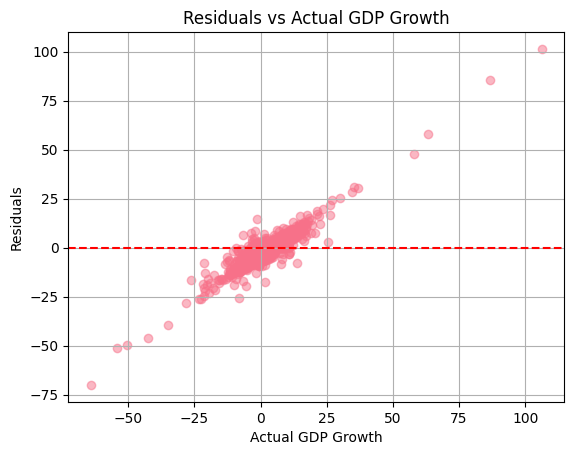

In [99]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual GDP Growth")
plt.ylabel("Residuals")
plt.title("Residuals vs Actual GDP Growth")
plt.grid(True)
plt.show()

### I can see from this:

That my model works reasonably well for the central GDP values (say, -10% to +20%), but fails to generalize to extreme economic scenarios, likely because:
- These are rare in your training data
- The model is regularized and can’t fit these extremes
- Outliers dominate RMSE and especially MAPE

### Things I could do to fix this:

-   1. Clipping or Winsorizing Target Values: Limit extreme GDP growth values (e.g., clipping to [-25%, +25%])

        + Simple and fast to implement.
        + Reduces the impact of extreme outliers on RMSE and overfitting.
        + Preserves the interpretability of the target.

        - You lose information about real (but rare) economic scenarios.
        - Can bias the model if those clipped values are frequent in certain countries or years.
        - Makes it impossible to predict values beyond the chosen range.

    Warnings:  This is best when outliers are rare and not critical to your use case.


-   2.  Log-Transforming (or Box-Cox) the Target: Apply np.log1p() to reduce skew in GDP growth.

        + Helps normalize skewed distribution.
        + Compresses large values and reduces the dominance of outliers.

        - GDP growth can be negative, and log1p() is undefined for values < -1
        - Predictions must be transformed back, which introduces distortion or error when reversing.
        - Makes it impossible to predict values beyond the chosen range.

    Warnings:  This would be best if we´d want smooth behavior and have mostly positive or shifted GDP values.


-   3. Remove or Segment Outliers:Detect and remove extreme GDP entries or treat them as a separate model task

        + Clean training data leads to better average-case performance.
        + Allows for a specialized model on extreme cases if needed.

        - Requires manual analysis or rules to define what’s “extreme.”
        - May exclude real-world, high-impact cases from your model.
        - Breaks the “global” nature of GDP forecasting across countries.

    Warnings:  This would be best if our outliers were rare and clearly different from your core dataset (e.g., conflict states, pandemics).

-   4. Robust Loss Functions (huber, quantile, fair): Change the LightGBM loss function to reduce sensitivity to outliers.

        + No need to modify the target or features..
        + Directly reduces the influence of extreme residuals.
        + Keeps model predictions realistic and better generalizing.

        - Slightly slower training.
        - Some loss functions (e.g., quantile) require parameter tuning (alpha).
        - May smooth too much and underfit high-variance targets.

    Warnings:  This would be best if we´d want to keep the full data but reduce outlier sensitivity smartly.


In [101]:
#Saving model
import pickle

# Save model
with open('best_lightgbm_pipeline.pkl', 'wb') as f:
    pickle.dump(best_model, f)